# Exploratory Data Analysis

- 1. [Introduction](#1.-Introduction)
- 2. [Imports](#2-Imports)
- 3. [Loading the data](#3.-Loading-the-data)
- 4. [Checking for Imbalanced Data](#4.-Checking-for-Imbalanced-Data)
- 5. [Discharges](#5.-Discharges)
- 6. [Demographics](#6.-Demographics)
    - 6.1 Race
    - 6.2 Gender
    - 6.3 Age
- 7. [Healthcare Payment Type](#7.-Healthcare-Payment-Type)
- 8. [Medical Specialty](#8.-Medical-Specialty)
- 9. [Patient Admission](#9.-Patient-Admission)
    - 9.1 Admission Type
    - 9.2 Admission Source
- 10. [Administered Tests](#10.-Administered-Tests)
    - 10.1 HbA1c Test
    - 10.2 Glucose Serum Test
- 11. [Diagnoses](#11.-Diagnoses)
    - 11.1 Primary Diagnosis
    - 11.2 Secondary Diagnosis
    - 11.3 Tertiary Diagnosis
    - 11.4 Number of Diagnoses
- 12. [Medication-related features](#12.-Medication-related-features)
    - 12.1 Change
    - 12.2 Diabetes Medication
    - 12.3 Specific Medications
- 13. [Numerical features](#13.-Numerical-features)
    - 13.1 Pair plots and correlation
    - 13.2 Distribution Shapes and Normality
    - 13.3 Combined Features
    - 13.4 Dimensionality Reduction and Visualization
- 14. [Conclusion](#14.-Conclusion)

## 1. Introduction

In the previous data wrangling phase, we enforced statistical independence in our raw diabetes dataset, addressed missing values, re-categorized nominal features, and identified outliers. We deferred removing outliers until feature engineering so these outstanding values will be present in our visualizations.

In this phase, we perform exploratory data analysis to identify patterns that may prove useful in predicting early readmission.


## 2. Imports

In [135]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.text import Text
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import scipy.stats as ss
from statsmodels.graphics.gofplots import qqplot

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from src.data import load_dataset as ld
from src.features.icd9 import icd9_to_classification, is_diabetes_mellitus, icd9_to_category
from src.features.age import age_to_index
from src.features.outliers import outliers_by_iqr
from src.visualization import visualize as viz

sns.set()
pd.options.display.max_columns = 100

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 3. Loading the data
We load a dataframe of diabetic patient encounters from a local pickle file.

In [2]:
df = ld.load_interim_pickle('00_diabetes.pkl')
original_shape = df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 71518 entries, (12522, 48330783) to (443867222, 175429310)
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   race                      71518 non-null  object  
 1   gender                    71518 non-null  object  
 2   age                       71518 non-null  object  
 3   admission_type_id         71518 non-null  category
 4   discharge_disposition_id  71518 non-null  category
 5   admission_source_id       71518 non-null  category
 6   days_in_hospital          71518 non-null  int64   
 7   payer_code                71518 non-null  category
 8   medical_specialty         71518 non-null  category
 9   num_lab_procedures        71518 non-null  int64   
 10  num_procedures            71518 non-null  int64   
 11  num_medications           71518 non-null  int64   
 12  number_outpatient         71518 non-null  int64   
 13  number_emerge

In [3]:
# Separating the numeric features for continuous feature EDA
numerical_features = ['age', 'days_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']

## 4. Checking for Imbalanced Data


In [4]:
df.is_readmitted_early.value_counts()

0    65225
1     6293
Name: is_readmitted_early, dtype: int64

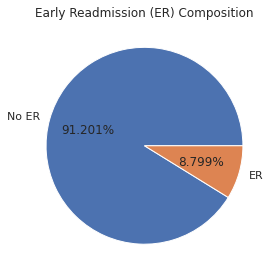

In [5]:
viz.pie_plot(feature_name='is_readmitted_early', df=df, title='Early Readmission (ER) Composition')

There is a noticeable imbalance between the classes in our target feature: there are many more patient encounters with no early readmission (about 91.2% of the dataset) than those who with early readmission (about 8.8% of the dataset). This implies that accuracy may not be a good measure to indicate success, as an naive learner that predicts no early readmission 100% of the time will yield over a 91% accuracy. Using a confusion matrix, precision, recall, and other metrics in combination with accuracy may help establish a better idea on how our learner is performing. Alternatively, this may lead us to re-sample the dataset to restore balance or generating synthetic samples.

## 5. Discharges

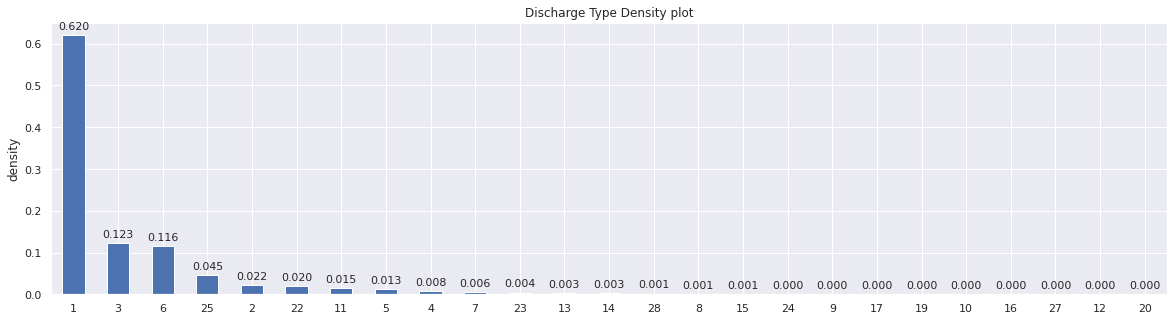

In [6]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(20)
viz.density_bar_plot(feature_name='discharge_disposition_id', df=df, ax=ax, title='Discharge Type Density plot')

Naturally, we find that the largest category is having the patient discharged to their home (id=1 at ~63%). We also observe that most of the dataset is accounted by the first 5 categories. Another observation is that there are discharge categories related to hospice or death, which means that these patients will definitely not be readmitted to the hospital. These features include:
- Expired
- Hospice / home
- Hospice / medical facility
- Expired at home. Medicaid only, hospice.
- Expired in a medical facility. Medicaid only, hospice.
- Expired, place unknown. Medicaid only, hospice.

How many of the patient encounters fit into these categories? 

In [7]:
non_readmissible_features = [11, 13, 14, 19, 20, 21]
non_readmissable_encounters = df[df.discharge_disposition_id.isin(non_readmissible_features)]
non_readmissable_encounters

,,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,days_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,is_readmitted_early
encounter_id,patient_nbr,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
293118,3327282,Caucasian,Female,[70-80),2,11,2,5,NA,Not Available,46,2,20,0,0,0,428,585,414,9,Not Available,Not Available,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,0
450210,80177094,Caucasian,Female,[80-90),1,11,7,7,NA,Not Available,72,1,27,0,0,0,432,997,427,9,Not Available,Not Available,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,0
712350,110537262,AfricanAmerican,Female,[50-60),1,11,7,4,NA,Not Available,58,1,16,0,0,0,403,V45,599,9,Not Available,Not Available,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,0
1069716,34806888,Caucasian,Female,[50-60),2,11,4,2,NA,Not Available,35,1,10,1,0,0,997,427,403,8,Not Available,Not Available,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,0
1260312,38688588,Caucasian,Male,[70-80),1,11,7,9,NA,Not Available,56,2,30,0,0,0,410,491,276,9,Not Available,Not Available,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436732496,41514156,Caucasian,Female,[70-80),1,13,7,5,MC,Not Available,60,3,19,1,0,0,183,560,276,8,Not Available,Not Available,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,0
437832998,145903622,Other,Female,[80-90),1,11,7,2,MC,Not Available,45,3,8,0,0,0,430,518,403,9,Not Available,Not Available,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0
438411458,94120866,Caucasian,Female,[60-70),2,19,7,1,UN,Emergency/Trauma,42,3,8,0,0,0,423,997,427,7,Not Available,Not Available,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0


Because this is a non-trivial fraction of our dataset, we will remove these observations to avoid affecting our data analysis. We will also perform this step during pre-processing.

In [8]:
df = df.drop(non_readmissable_encounters.index, errors='ignore')
del non_readmissable_encounters

In [9]:
df.discharge_disposition_id = df.discharge_disposition_id.cat.remove_unused_categories()

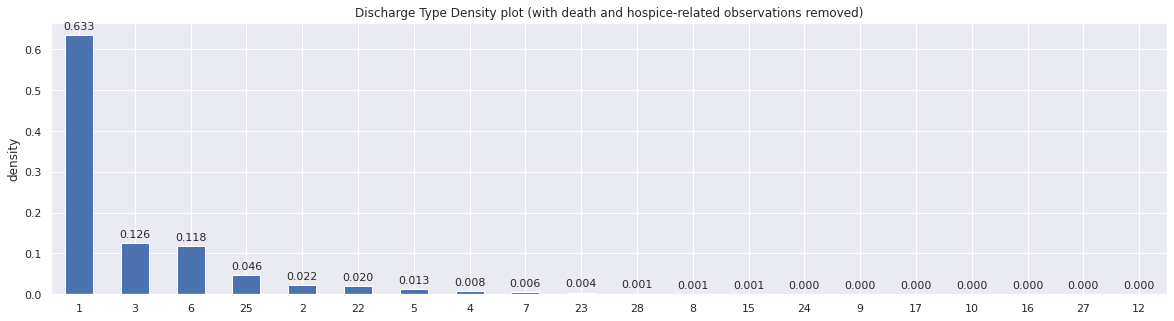

In [10]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(20)
viz.density_bar_plot(feature_name='discharge_disposition_id', df=df, ax=ax, title='Discharge Type Density plot (with death and hospice-related observations removed)')


We now take the top 10 largest discharge categories and determine if there is a noticeable difference among them with respect to early readmission.
- **Discharged to home**: A routine discharge to the patient's home, jail, or law enforcement
- **Discharged/transferred to SNF**: A transfer to a skilled nursing facility for patients that require rehabilitation, eldercare, physical, occupational, or speech therapy.
- **Discharged/transferred to home with home health service**: Discharged with a plan of home care written by medical professionals.
- **Unknown/Invalid**: A discharge type that is not known.
- **Discharged/transferred to another short term hospital** 
- **Discharged/transferred to another rehab fac including rehab units of a hospital**
- **Discharged/transferred to another type of inpatient care institution**
- **Not Mapped**: A provided description of discharge that did not correspond to an existing code.
- **Discharged/transferred to ICF**: A transfer to an intermediate care facility, typically state-designated.
- **Left AMA**: Left against medical advice

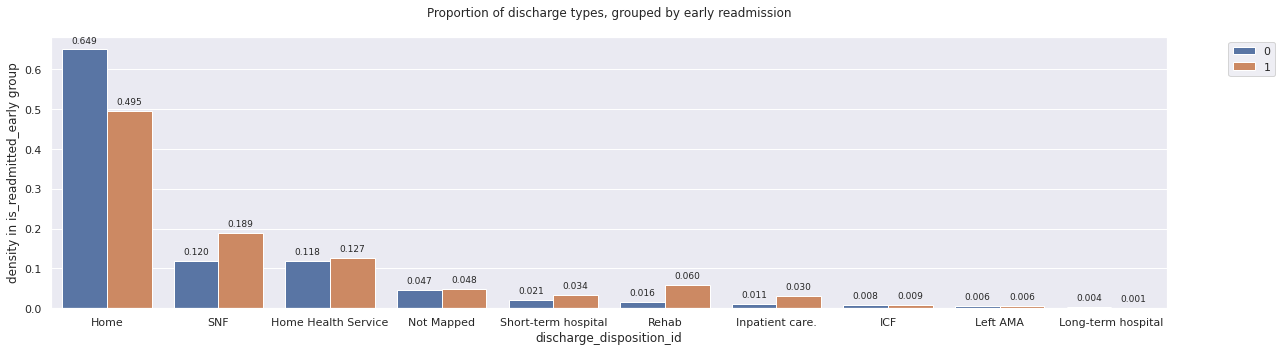

In [11]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(20)

nlargest_counts = df.discharge_disposition_id.value_counts(normalize=True).sort_values(ascending=False).nlargest(10)
nlargest_index = nlargest_counts.index
nlargest_labels = ['Home', 'SNF', 'Home Health Service', 'Not Mapped', 'Short-term hospital', 'Rehab', 'Inpatient care.', 'ICF', 'Left AMA', 'Long-term hospital']

tmp = df[df.discharge_disposition_id.isin(nlargest_index)].copy()
tmp.loc[:, 'discharge_disposition_id'] = tmp.discharge_disposition_id.cat.remove_unused_categories()

viz.grouped_bar_plot(feature_name='discharge_disposition_id', df=tmp, ax=ax,
                     groupby='is_readmitted_early', order=nlargest_index.tolist(),
                     title='Proportion of discharge types, grouped by early readmission',
                     xlabels=nlargest_labels)

Patients who have been readmitted early (0.495) have a much smaller proportion of incidences where they were discharged to their home than those who have not been readmitted early (0.649). This deficiency is compensated in the skilled nursing facility and home health service categories, implying that those who are more likely to be readmitted need more skilled attention and care.

## 6. Demographics

### 6.1. Race

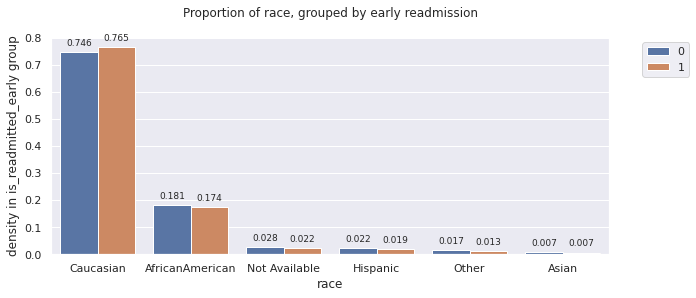

In [12]:
viz.grouped_bar_plot(feature_name='race', df=df,
                     groupby='is_readmitted_early',
                     title='Proportion of race, grouped by early readmission')

### 6.2. Gender

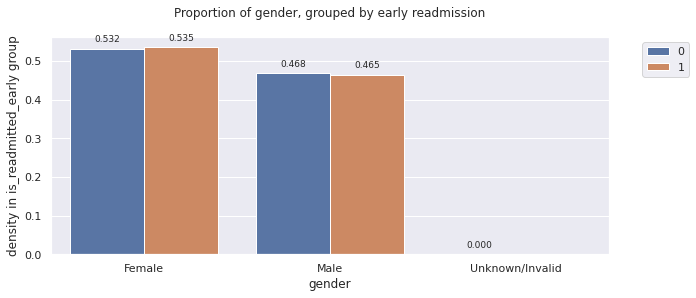

In [13]:
viz.grouped_bar_plot(feature_name='gender', df=df,
                     groupby='is_readmitted_early',
                     title='Proportion of gender, grouped by early readmission')

There appears to be a relatively even amount of male and female patients across gender. There are only three unknown or invalid gender values and they have all not been readmitted early. 

In [14]:
df[df.gender == 'Unknown/Invalid']

,,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,days_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,is_readmitted_early
encounter_id,patient_nbr,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
98634858,100695042,Other,Unknown/Invalid,[70-80),3,1,1,1,NA,Cardiology,5,5,22,0,0,0,414,411,401,4,Not Available,Not Available,No,No,No,No,No,No,Steady,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,Ch,Yes,0
226864668,60524946,Not Available,Unknown/Invalid,[60-70),1,1,7,1,CP,Not Available,38,1,6,0,0,0,808,873,E813,5,Not Available,Not Available,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0
257364294,78119847,Not Available,Unknown/Invalid,[70-80),1,22,7,8,CP,Not Available,59,2,21,0,0,0,850,805,808,9,Not Available,Not Available,Steady,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,Ch,Yes,0


### 6.3. Age 

Age is an ordinal categorical variable. We expect that the average age of patients who were readmitted early to be slightly higher than patients who have not because of age-induced susceptibility to illness.

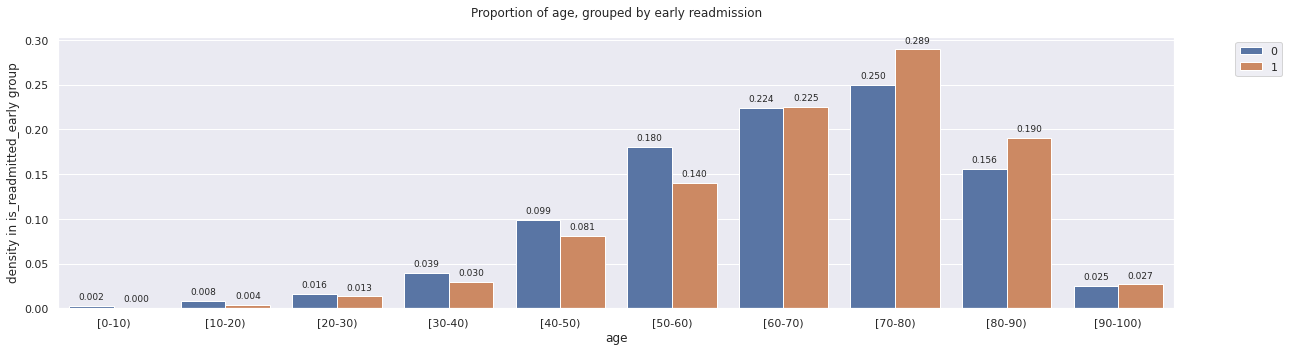

In [15]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(20)

viz.grouped_bar_plot(feature_name='age', df=df, ax=ax,
                     order=sorted(df.age.unique()),
                     groupby='is_readmitted_early',
                     title='Proportion of age, grouped by early readmission')

There is a higher proportion of patients within the \[70-80) (\~0.29 and \~0.25) and \[80-90) (\~0.19 vs \~0.16) age bracket that were readmitted early than not. Conversely, patients who were not readmitted early had a higher proportion  of patients within the \[50-60) bracket (\~0.18 and ~0.14) than those who were readmitted early.



## 7. Healthcare Payment Type

Payer code defines with which healthcare company or plan the patient they paid for their care. 


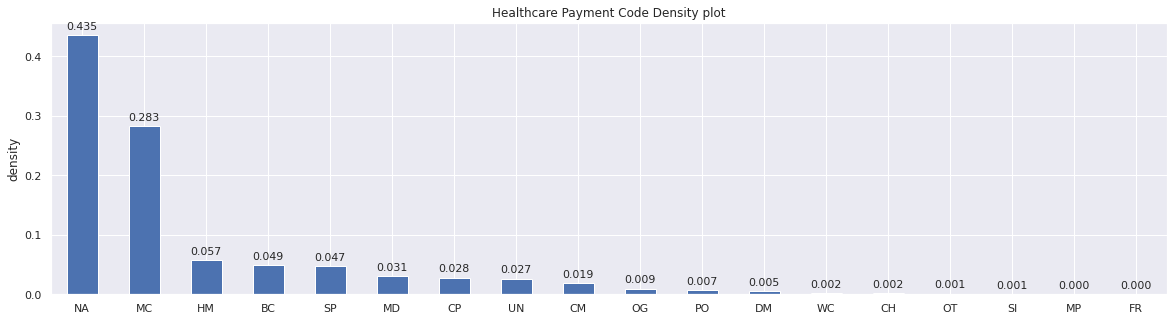

In [16]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(20)
viz.density_bar_plot(feature_name='payer_code', df=df, ax=ax, title='Healthcare Payment Code Density plot')

About 43.5% of the payment codes are not available. The second most common is Medicare (MC), which accounts for about 28.3%. We will see if this distribution changes between early readmission statuses: 

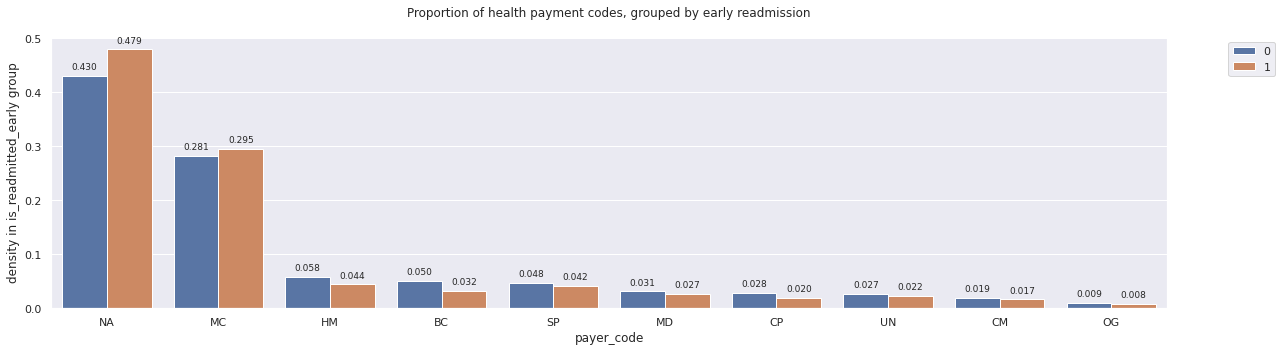

In [17]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(20)


nlargest_counts = df.payer_code.value_counts(normalize=True).sort_values(ascending=False).nlargest(10)
nlargest_index = nlargest_counts.index

tmp = df[df.payer_code.isin(nlargest_index)].copy()
tmp.loc[:, 'payer_code'] = tmp.payer_code.cat.remove_unused_categories()


viz.grouped_bar_plot(feature_name='payer_code', df=df, ax=ax,
                     groupby='is_readmitted_early',
                     order=nlargest_index.tolist(),
                     title='Proportion of health payment codes, grouped by early readmission')

There is a slight difference between the proportions of Not Available and Medicare payments between the early readmission groups. We may be able to bucket all other payer codes outside of the top ten into an 'Other' category since they account for so little of the dataset.

## 8. Medical Specialty
This feature represents the specialty of the admitting physician. There are several different specialties that only account for a small portion of the observations in the data. We'll focus on the top 10.

In [18]:
df.medical_specialty.nunique()

71

In [19]:
medical_specialty_cum_sum = df.medical_specialty.value_counts(normalize=True, dropna=False).cumsum()
medical_specialty_cum_sum[medical_specialty_cum_sum <= 0.90].count()

8

Only 8 medical specialties account for 90% of observations. We will only focus on the top 8 medical specialties.

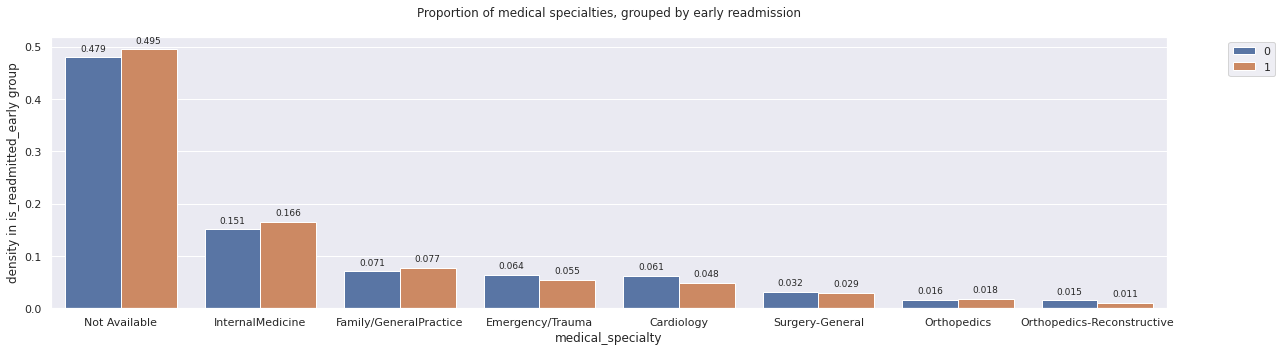

In [20]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(20)

nlargest_counts = df.medical_specialty.value_counts(normalize=True).sort_values(ascending=False).nlargest(8)
nlargest_index = nlargest_counts.index

tmp = df[df.medical_specialty.isin(nlargest_index)].copy()
tmp.loc[:, 'medical_specialty'] = tmp.medical_specialty.cat.remove_unused_categories()


viz.grouped_bar_plot(feature_name='medical_specialty', df=df, ax=ax,
                     groupby='is_readmitted_early',
                     order=nlargest_index.tolist(),
                     title='Proportion of medical specialties, grouped by early readmission')

Patient encounters that did not result in early readmission had a lower proportion of Not Available medical specialties, which may mean that these patients did not require a specialist. However, this difference may not be meaningful in distinguishing the two groups.

## 9. Patient Admission

Admission is described in two ways: admission type (the type of reason for the patient admission) and admission source (a description on where the patient came from).

### 9.1. Admission Type



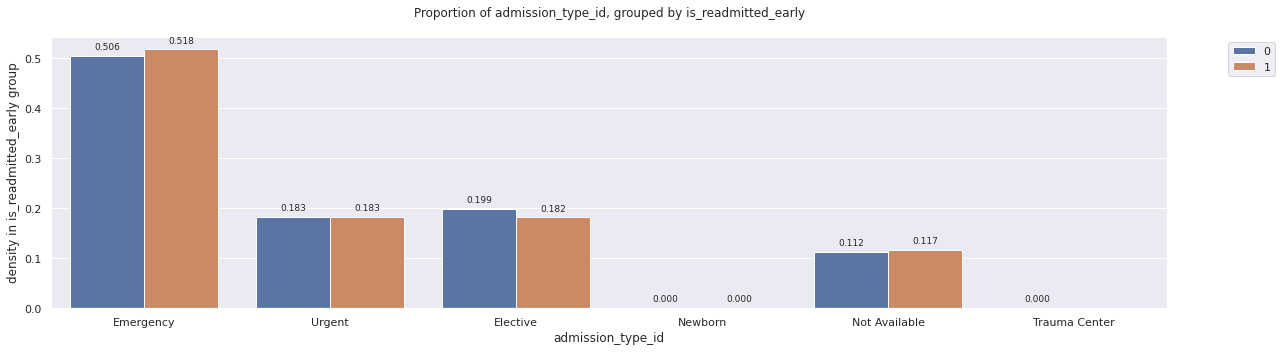

In [21]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(20)

viz.grouped_bar_plot(feature_name='admission_type_id', df=df, ax=ax, groupby='is_readmitted_early')
_ = ax.set_xticklabels(ld.convert_id_to_admission_type(pd.Series([int(l.get_text()) for l in ax.get_xticklabels()])).tolist())

### 9.2. Admission Source

Only a small subset of the categories account for over 90% of our observations.

In [22]:
admission_source_cumsum = df.admission_source_id.value_counts(normalize=True).cumsum()
admission_source_cumsum[admission_source_cumsum <= 0.95].count()

3

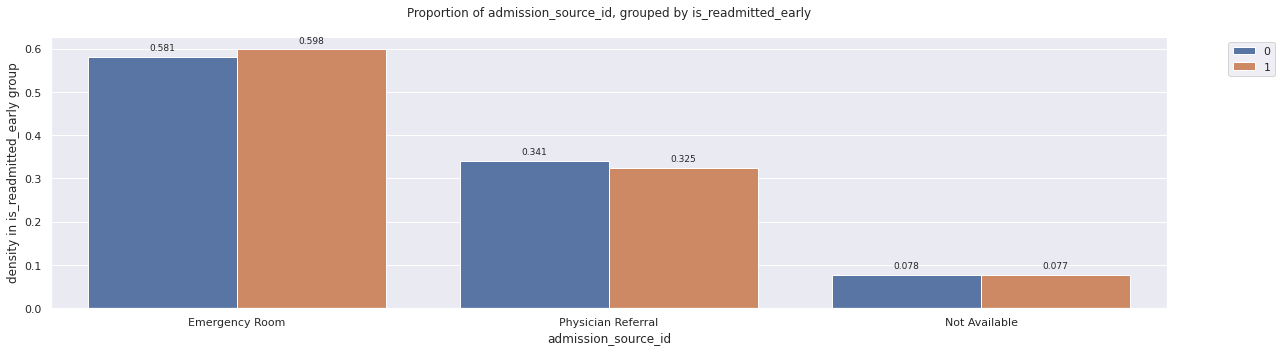

In [23]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(20)

nlargest_counts = df.admission_source_id.value_counts(normalize=True).sort_values(ascending=False).nlargest(3)
nlargest_index = nlargest_counts.index

tmp = df[df.admission_source_id.isin(nlargest_index)].copy()
tmp.loc[:, 'admission_source_id'] = tmp.admission_source_id.cat.remove_unused_categories()

viz.grouped_bar_plot(feature_name='admission_source_id', df=tmp, ax=ax, groupby='is_readmitted_early', order=nlargest_index)
_ = ax.set_xticklabels(ld.convert_id_to_admission_source(pd.Series([int(l.get_text()) for l in ax.get_xticklabels()])).tolist())

Emergency patient encounters account for the largest portion of the dataset. Patients who were readmitted early have a higher proportion of emergency room admission sources than those who were not.

## 10. Administered Tests

### 10.1. HbA1c Result

In [24]:
df.groupby('is_readmitted_early').A1Cresult.value_counts(normalize=True)

is_readmitted_early  A1Cresult    
0                    Not Available    0.815263
                     >8               0.089959
                     Norm             0.053661
                     >7               0.041117
1                    Not Available    0.828262
                     >8               0.081090
                     Norm             0.051458
                     >7               0.039191
Name: A1Cresult, dtype: float64

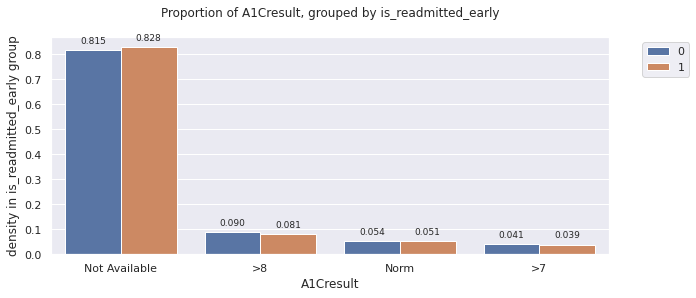

In [25]:
viz.grouped_bar_plot(feature_name='A1Cresult', df=df, groupby='is_readmitted_early')

### 10.2. Glucose Serum Test

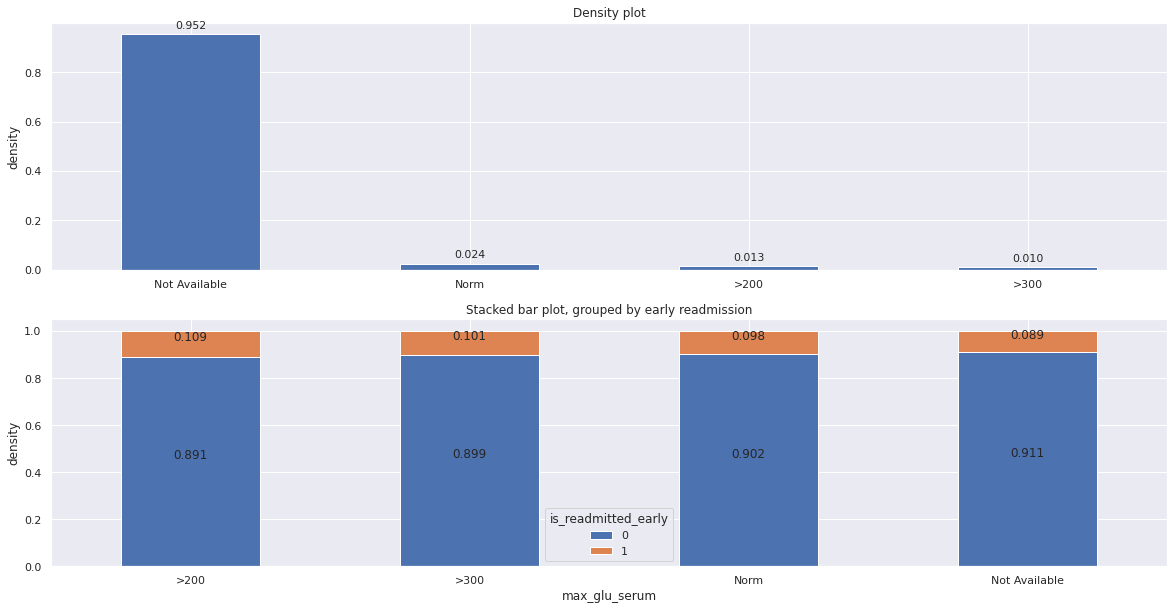

In [26]:
fig, axes = plt.subplots(2, 1)
fig.set_figheight(10)
fig.set_figwidth(20)

viz.density_bar_plot(feature_name='max_glu_serum', df=df, ax=axes[0], title='Density plot')
viz.stacked_bar_plot(feature_a='max_glu_serum', feature_b='is_readmitted_early', df=df, ax=axes[1], title='Stacked bar plot, grouped by early readmission')

## 11. Diagnoses
Diagnoses for each patient are defined by primary, secondary, and tertiary diagnoses. The delineation among these three groups is not clearly defined, but the primary diagnosis is assumed to be primarily responsible for the patient's hospitalization.

According to [Strack et al](https://www.hindawi.com/journals/bmri/2014/781670/):
- "The primary diagnosis (coded as first three digits of ICD9); 848 distinct values"
- "Secondary diagnosis (coded as first three digits of ICD9); 923 distinct values"
- "Additional secondary diagnosis (coded as first three digits of ICD9); 954 distinctvalues"

To increase interpretability, we translate these ICD-9 codes to a human readable format.
### 11.1. Primary Diagnosis
We observe that 11 categories account for 95% of observations so we will visualize those 11 and categorize the remainder as Other:

In [27]:
diagnoses = df.copy()
diagnoses['diag_1'] = diagnoses.diag_1.apply(lambda x: icd9_to_classification(x, concise=True))
diagnoses.loc[diagnoses.diag_1.isnull(), 'diag_1'] = 'Not Available'

diagnosis_categories = df.copy()
diagnosis_categories['diag_1'] = diagnosis_categories.diag_1.apply(icd9_to_category)

diag_1_cumsum = diagnoses.diag_1.value_counts(normalize=True, dropna=False).cumsum()
diag_1_cumsum[diag_1_cumsum <= 0.95].count()

11

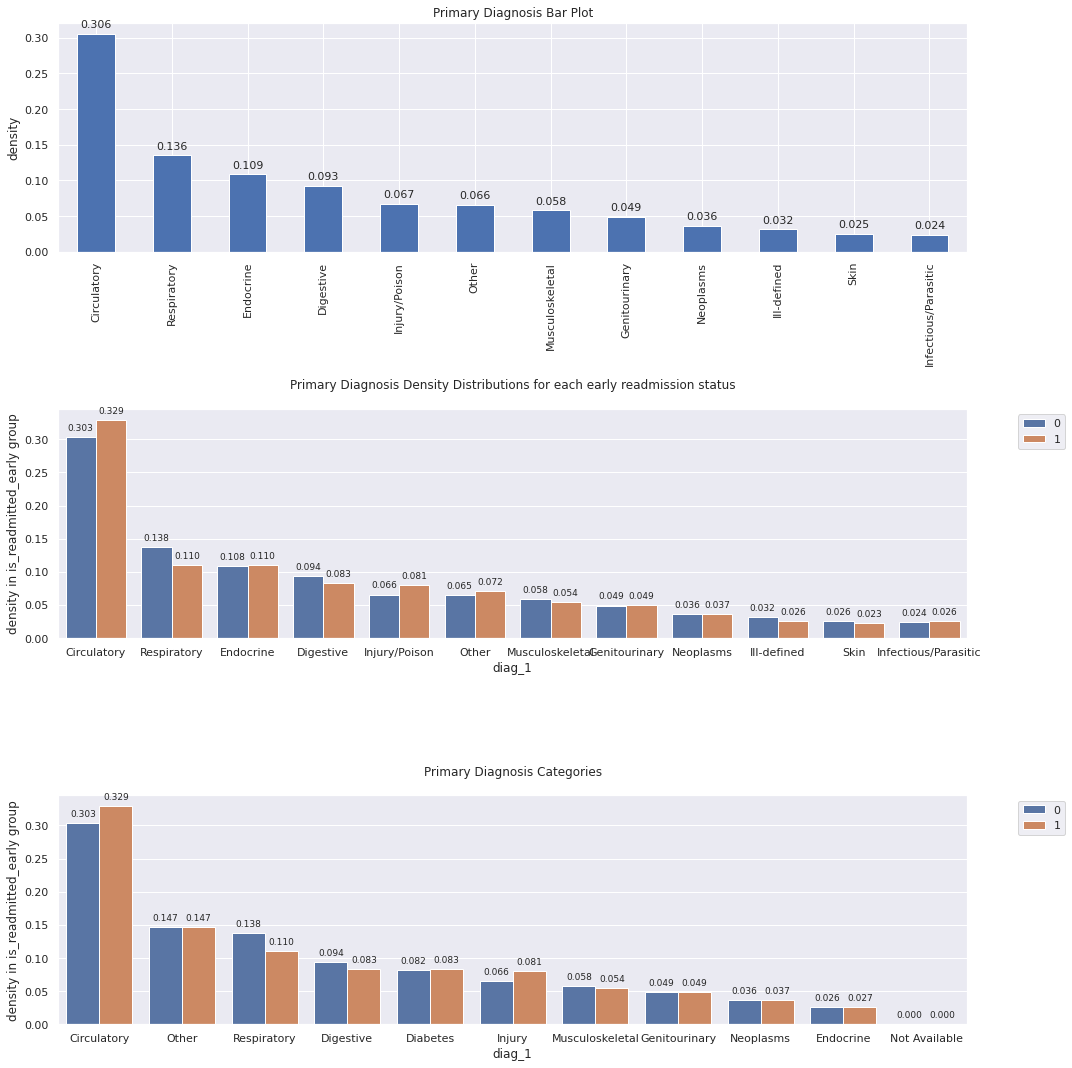

In [28]:
fig, axes = plt.subplots(3, 1)
fig.set_figheight(15)
fig.set_figwidth(15)

nlargest_counts = diagnoses.diag_1.value_counts(normalize=True).sort_values(ascending=False).nlargest(11)
nlargest_index = nlargest_counts.index

tmp = diagnoses.copy()
tmp.loc[~tmp.diag_1.isin(nlargest_index), 'diag_1'] = 'Other'

viz.density_bar_plot(feature_name='diag_1', df=tmp, ax=axes[0], rot=90, title='Primary Diagnosis Bar Plot')
viz.grouped_bar_plot(feature_name='diag_1', df=tmp, ax=axes[1], title='Primary Diagnosis Density Distributions for each early readmission status')
viz.grouped_bar_plot(feature_name='diag_1', df=diagnosis_categories, ax=axes[2], title='Primary Diagnosis Categories')
plt.tight_layout()

It appears that patients who were readmitted early have a noticeably higher incidence of circulatory issues as a primary diagnosis (0.355 vs 0.324). Similarly, non-early patients have a higher incidence of respiratory illness as a primary diagnosis (0.148 vs 0.119). Will we see this same pattern for secondary and tertiary diagnoses? 


In the third figure, we generalized the ICD9 codes into higher-level categories. We also extracted diabetes out of the Endocrine, nutritional, and metabolic diseases and immunity disorders classification. We do not observe a noticeable difference in the incidence of diabetes between the two groups.

### 11.2. Secondary Diagnosis

We observe that 12 categories account for 95% of observations so we will visualize those 12 and categorize the remainder as Other:

In [29]:
diagnoses['diag_2'] = diagnoses.diag_2.apply(lambda x: icd9_to_classification(x, concise=True))
diagnoses.loc[diagnoses.diag_2.isnull(), 'diag_2'] = 'Not Available'

diagnosis_categories['diag_2'] = diagnosis_categories.diag_2.apply(icd9_to_category)

diag_2_cumsum = diagnoses.diag_2.value_counts(normalize=True, dropna=False).cumsum()
diag_2_cumsum[diag_2_cumsum <= 0.95].count()

12

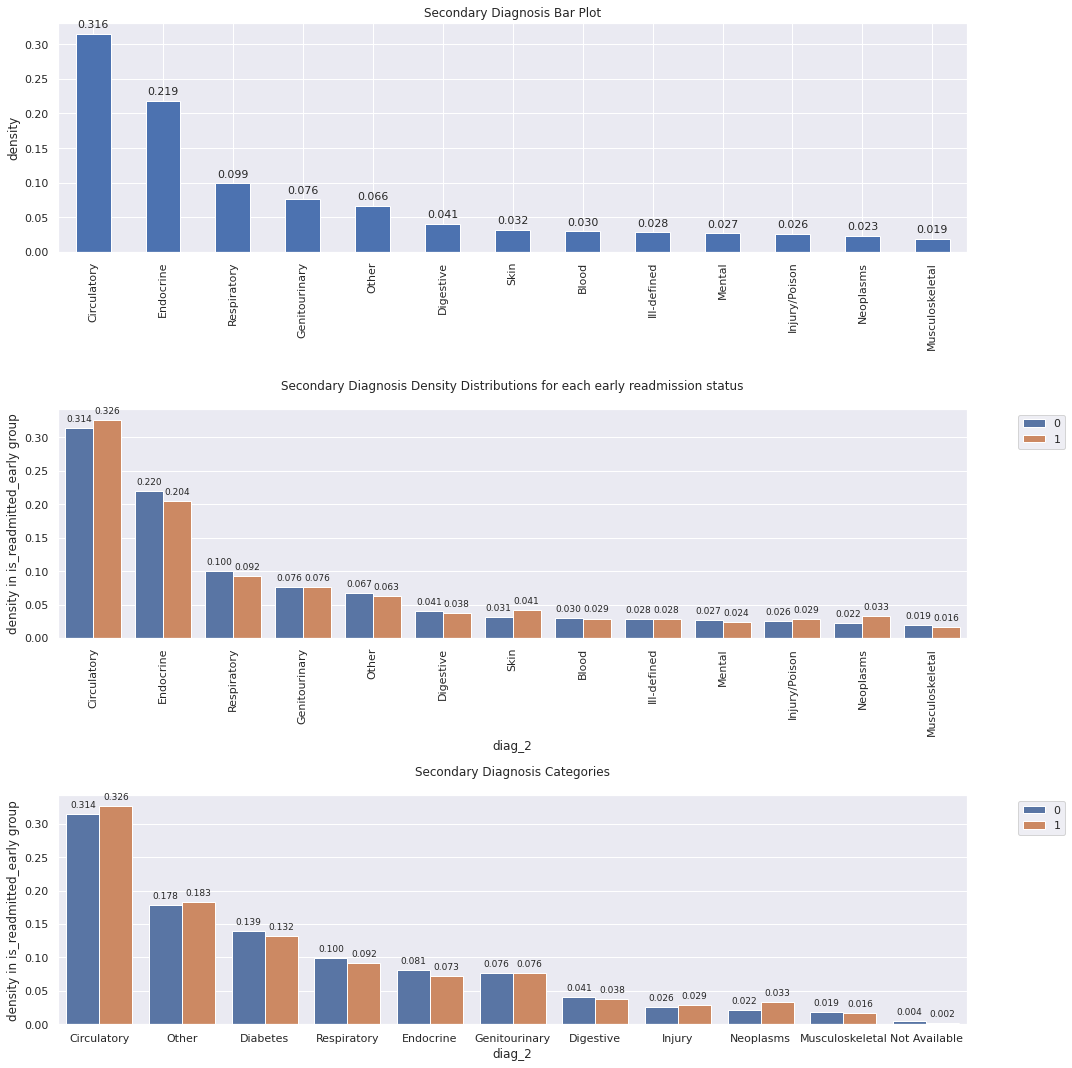

In [30]:
fig, axes = plt.subplots(3, 1)
fig.set_figheight(15)
fig.set_figwidth(15)

nlargest_counts = diagnoses.diag_2.value_counts(normalize=True).sort_values(ascending=False).nlargest(12)
nlargest_index = nlargest_counts.index

tmp = diagnoses.copy()
tmp.loc[~tmp.diag_2.isin(nlargest_index), 'diag_2'] = 'Other'

viz.density_bar_plot(feature_name='diag_2', df=tmp, ax=axes[0], rot=90, title='Secondary Diagnosis Bar Plot')
viz.grouped_bar_plot(feature_name='diag_2', df=tmp, ax=axes[1], rot=90, title='Secondary Diagnosis Density Distributions for each early readmission status')
viz.grouped_bar_plot(feature_name='diag_2', df=diagnosis_categories, ax=axes[2], title='Secondary Diagnosis Categories')
plt.tight_layout()

### 11.3. Tertiary Diagnosis
We observe that 14 categories account for 95% of observations so we will visualize those 14 and categorize the remainder as Other:

In [31]:
diagnoses['diag_3'] = diagnoses.diag_3.apply(lambda x: icd9_to_classification(x, concise=True))
diagnoses.loc[diagnoses.diag_3.isnull(), 'diag_3'] = 'Not Available'

diagnosis_categories['diag_3'] = diagnosis_categories.diag_3.apply(icd9_to_category)

diag_3_cumsum = diagnoses.diag_3.value_counts(normalize=True, dropna=False).cumsum()
diag_3_cumsum[diag_3_cumsum <= 0.95].count()

14

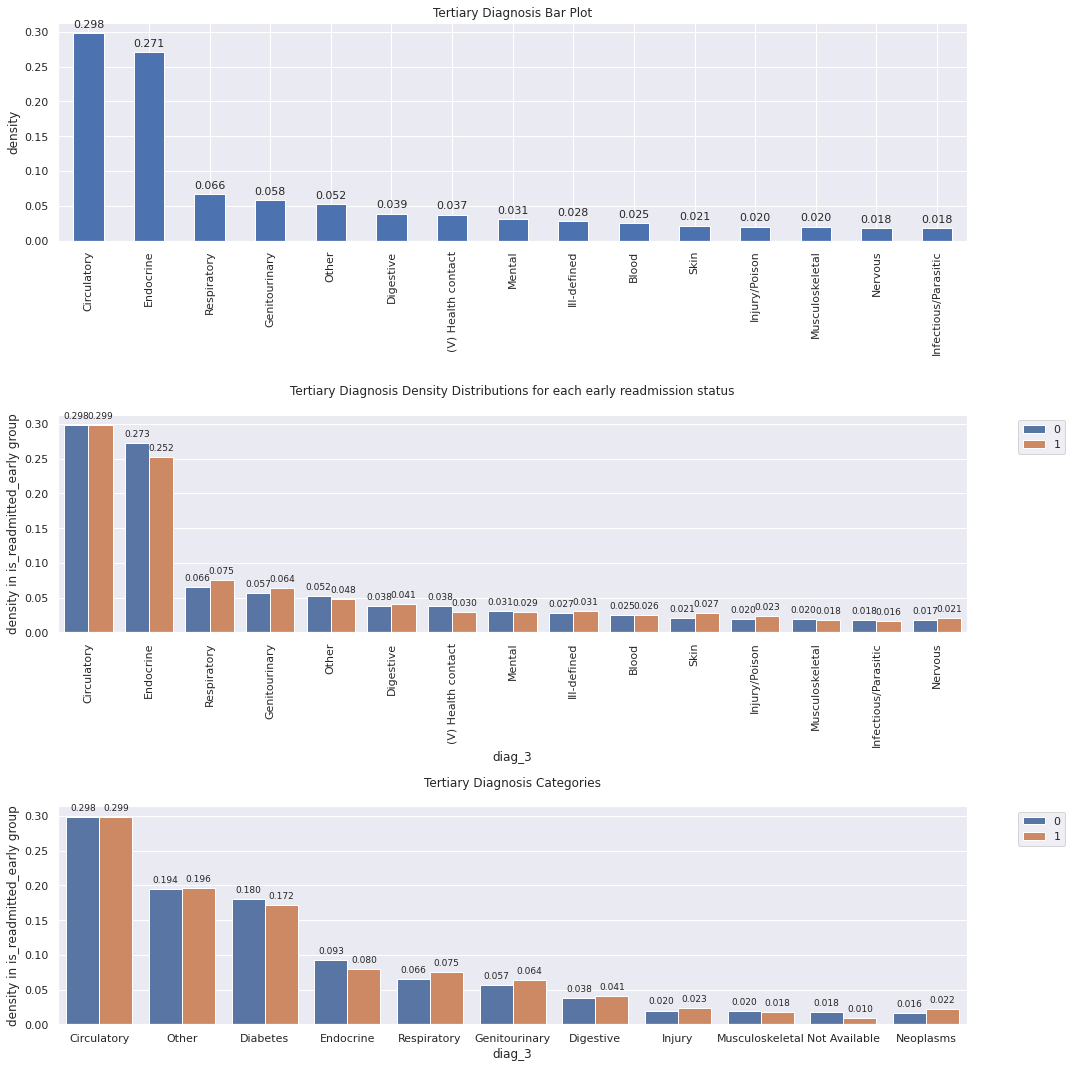

In [32]:
fig, axes = plt.subplots(3, 1)
fig.set_figheight(15)
fig.set_figwidth(15)

nlargest_counts = diagnoses.diag_3.value_counts(normalize=True).sort_values(ascending=False).nlargest(14)
nlargest_index = nlargest_counts.index

tmp = diagnoses.copy()
tmp.loc[~tmp.diag_3.isin(nlargest_index), 'diag_3'] = 'Other'

viz.density_bar_plot(feature_name='diag_3', df=tmp, ax=axes[0], rot=90, title='Tertiary Diagnosis Bar Plot')
viz.grouped_bar_plot(feature_name='diag_3', df=tmp, ax=axes[1], rot=90, title='Tertiary Diagnosis Density Distributions for each early readmission status')
viz.grouped_bar_plot(feature_name='diag_3', df=diagnosis_categories, ax=axes[2], title='Tertiary Diagnosis Categories')
plt.tight_layout()

We are interested in whether there is a noticeable difference in the inclusion of certain disease categories between those who have been readmitted early and those who have not. For example, among patients who have a circulatory disease as a diagnosis, what is the proportion that have been readmitted early and is that larger than that of the population who do not include that kind of diagnosis?

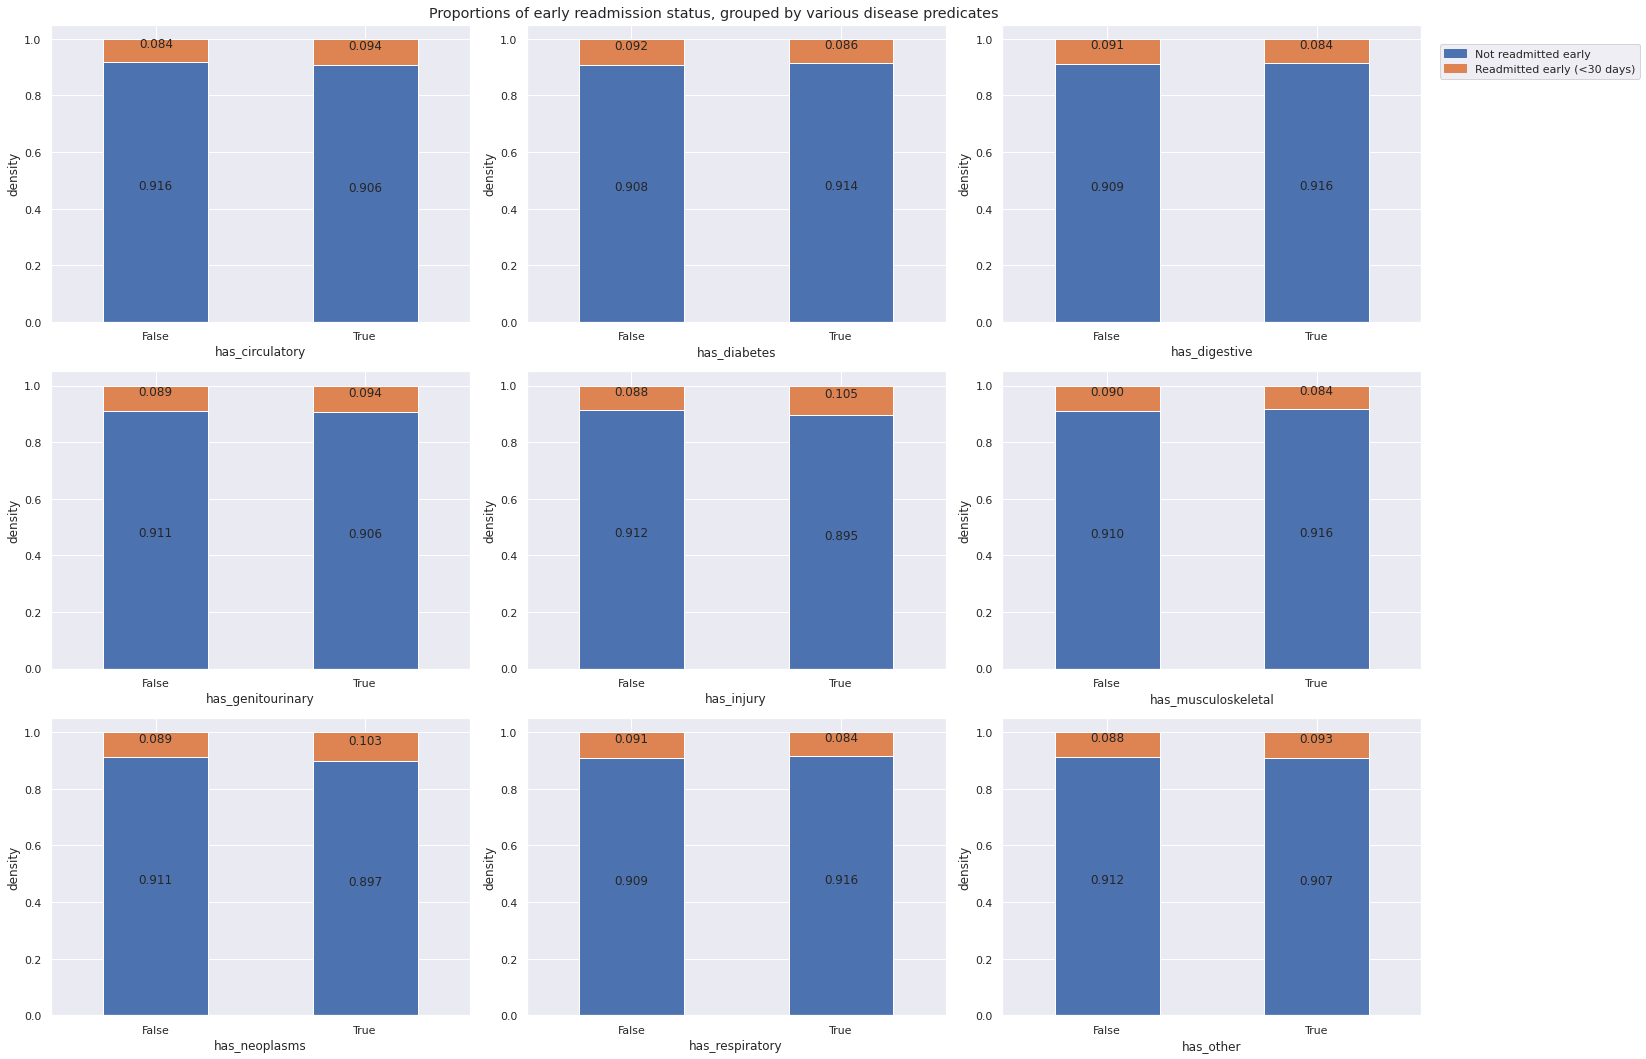

In [33]:
g = df.copy()
g.diag_1 = g.diag_1.apply(icd9_to_category)
g.diag_2 = g.diag_2.apply(icd9_to_category)
g.diag_3 = g.diag_3.apply(icd9_to_category)

diag_categories = ['Circulatory', 'Diabetes', 'Digestive', 'Genitourinary', 'Injury', 'Musculoskeletal', 'Neoplasms', 'Respiratory', 'Other']
boolean_categories = []

for c in diag_categories:
    f = 'has_' + c.lower()
    boolean_categories.append(f)
    g[f] = (g.diag_1 == c) | (g.diag_2 == c) | (g.diag_3 == c)
    
nrows=3
ncols=3
fig, axes = plt.subplots(nrows, ncols)
fig.set_figheight(15)
fig.set_figwidth(20)

for i, f in enumerate(boolean_categories):
    ax = axes[i // nrows, i % ncols]
    viz.stacked_bar_plot(feature_a=f, feature_b='is_readmitted_early', df=g, ax=ax, title='')
    ax.get_legend().remove()
  
blue = mpatches.Patch(color=sns.color_palette()[0], label='Not readmitted early')
orange = mpatches.Patch(color=sns.color_palette()[1], label='Readmitted early (<30 days)')
_ = fig.legend(handles=[blue, orange], loc='upper left', bbox_to_anchor=(1, 0.95))
_ = plt.suptitle('Proportions of early readmission status, grouped by various disease predicates')
plt.tight_layout()

There are slight proportional differences, the largest of which are injuries and neoplasms. Populations with sets of diagnoses that contain injuries or neoplams have a larger incidence of patients that have been readmitted early.

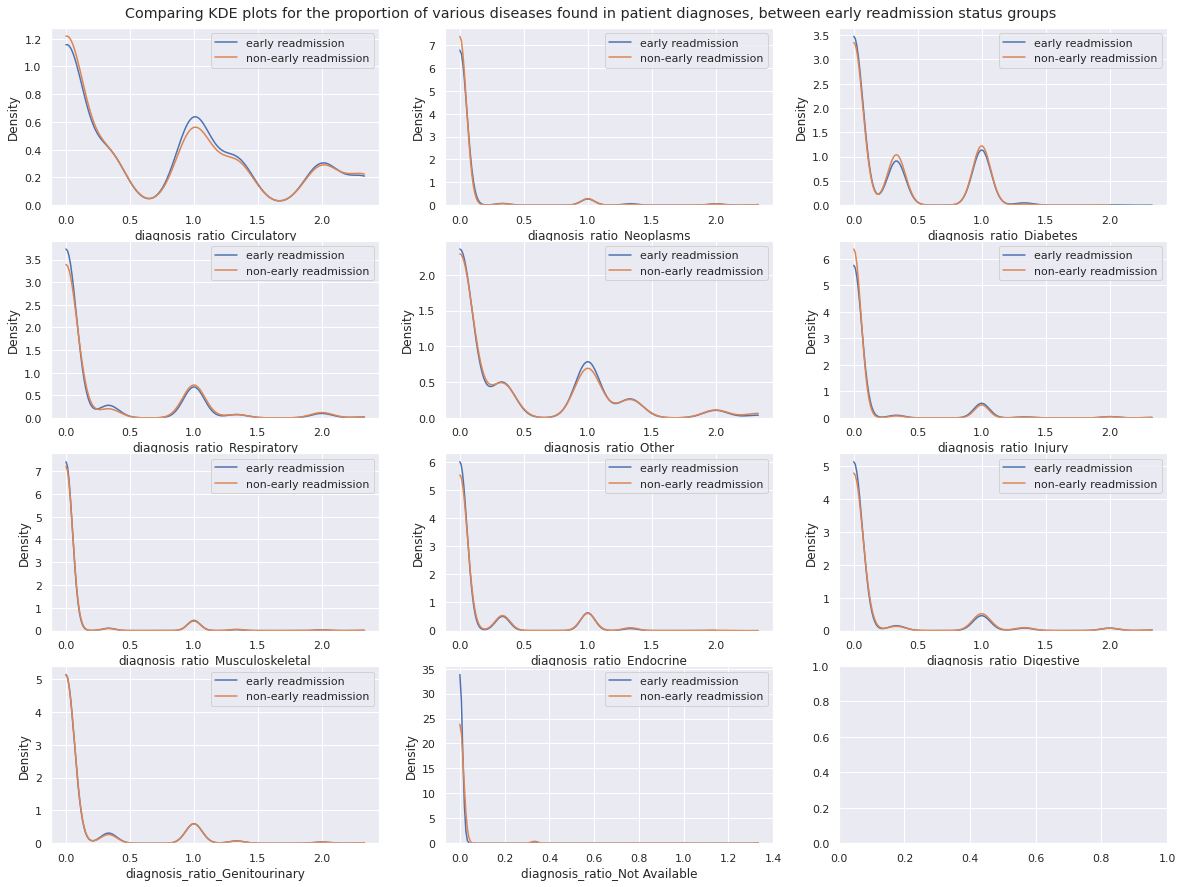

In [34]:
tmp = df.copy()
tmp.diag_1 = tmp.diag_1.apply(icd9_to_category)
tmp.diag_2 = tmp.diag_2.apply(icd9_to_category)
tmp.diag_3 = tmp.diag_3.apply(icd9_to_category)

categories = ['Circulatory', 'Neoplasms', 'Diabetes', 'Respiratory', 'Other',
       'Injury', 'Musculoskeletal', 'Endocrine', 'Digestive',
       'Genitourinary', 'Not Available']

for c in categories:
    tmp[f'diagnosis_ratio_{c}'] = (tmp.diag_1 == c).astype(int) + (tmp.diag_2 == c).astype(int) + (tmp.diag_3 == c).astype(int) / 3 


fig, axes = plt.subplots(4, 3)
fig.set_figheight(15)
fig.set_figwidth(20)

axes_iter = iter(axes.flatten())

early_readmits = tmp[tmp.is_readmitted_early == 1]
non_early_readmits = tmp[tmp.is_readmitted_early == 0]

for c in categories:
    ax = next(axes_iter)
    _ = sns.kdeplot(x=f'diagnosis_ratio_{c}', data=early_readmits, cut=0, ax=ax)
    _ = sns.kdeplot(x=f'diagnosis_ratio_{c}', data=non_early_readmits.sample(len(early_readmits)), cut=0, ax=ax)
    _ = ax.legend(['early readmission', 'non-early readmission'])
    
_ = plt.suptitle('Comparing KDE plots for the proportion of various diseases found in patient diagnoses, between early readmission status groups', y=0.9)

It's clear that the highest occurring diagnosis is circulatory diseases. There are slight differences in the density of the distribution when comparing circulatory disease proportions, but, like most of the other ratios, they are identical in shape.

### 11.4. Number of Diagnoses

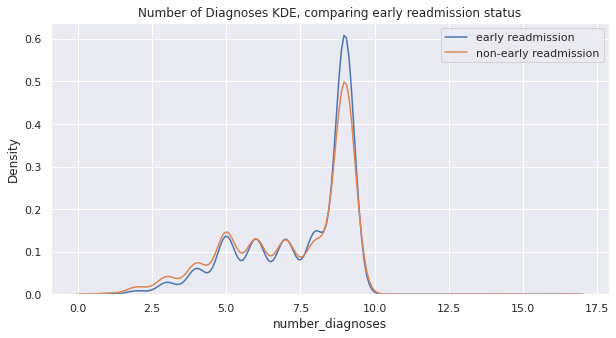

In [35]:
early_readmits = df[df.is_readmitted_early == 1]
non_early_readmits = df[df.is_readmitted_early == 0]

fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(10)

_ = sns.kdeplot(x='number_diagnoses', data=early_readmits, ax=ax)
_ = sns.kdeplot(x='number_diagnoses', data=non_early_readmits.sample(len(early_readmits)), ax=ax)
_ = ax.set_title('Number of Diagnoses KDE, comparing early readmission status')
_ = ax.legend(['early readmission', 'non-early readmission'])

## 12. Medication-related features 
### 12.1. Change
The `change` feature is a binary categorical feature that describes whether a patient has had their medication changed during their encounter.


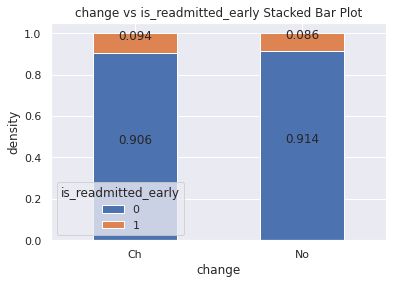

In [36]:
viz.stacked_bar_plot(feature_a='change', feature_b='is_readmitted_early', df=df)

Patients who are not readmitted early have a slightly higher proportion of those who did not change their medication during their patient encounter.

### 12.2. Diabetes Medication
The `diabetesMed` feature is a binary categorical feature that indicates whether or not the patient is on diabetes medication.

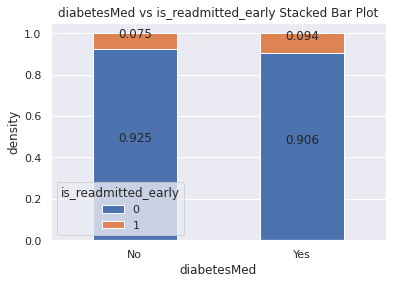

In [37]:
viz.stacked_bar_plot(feature_a='diabetesMed', feature_b='is_readmitted_early', df=df)

Patients who are readmitted early have a slightly higher proportion of those who are taking diabetes medication.

### 12.3. Specific Medications

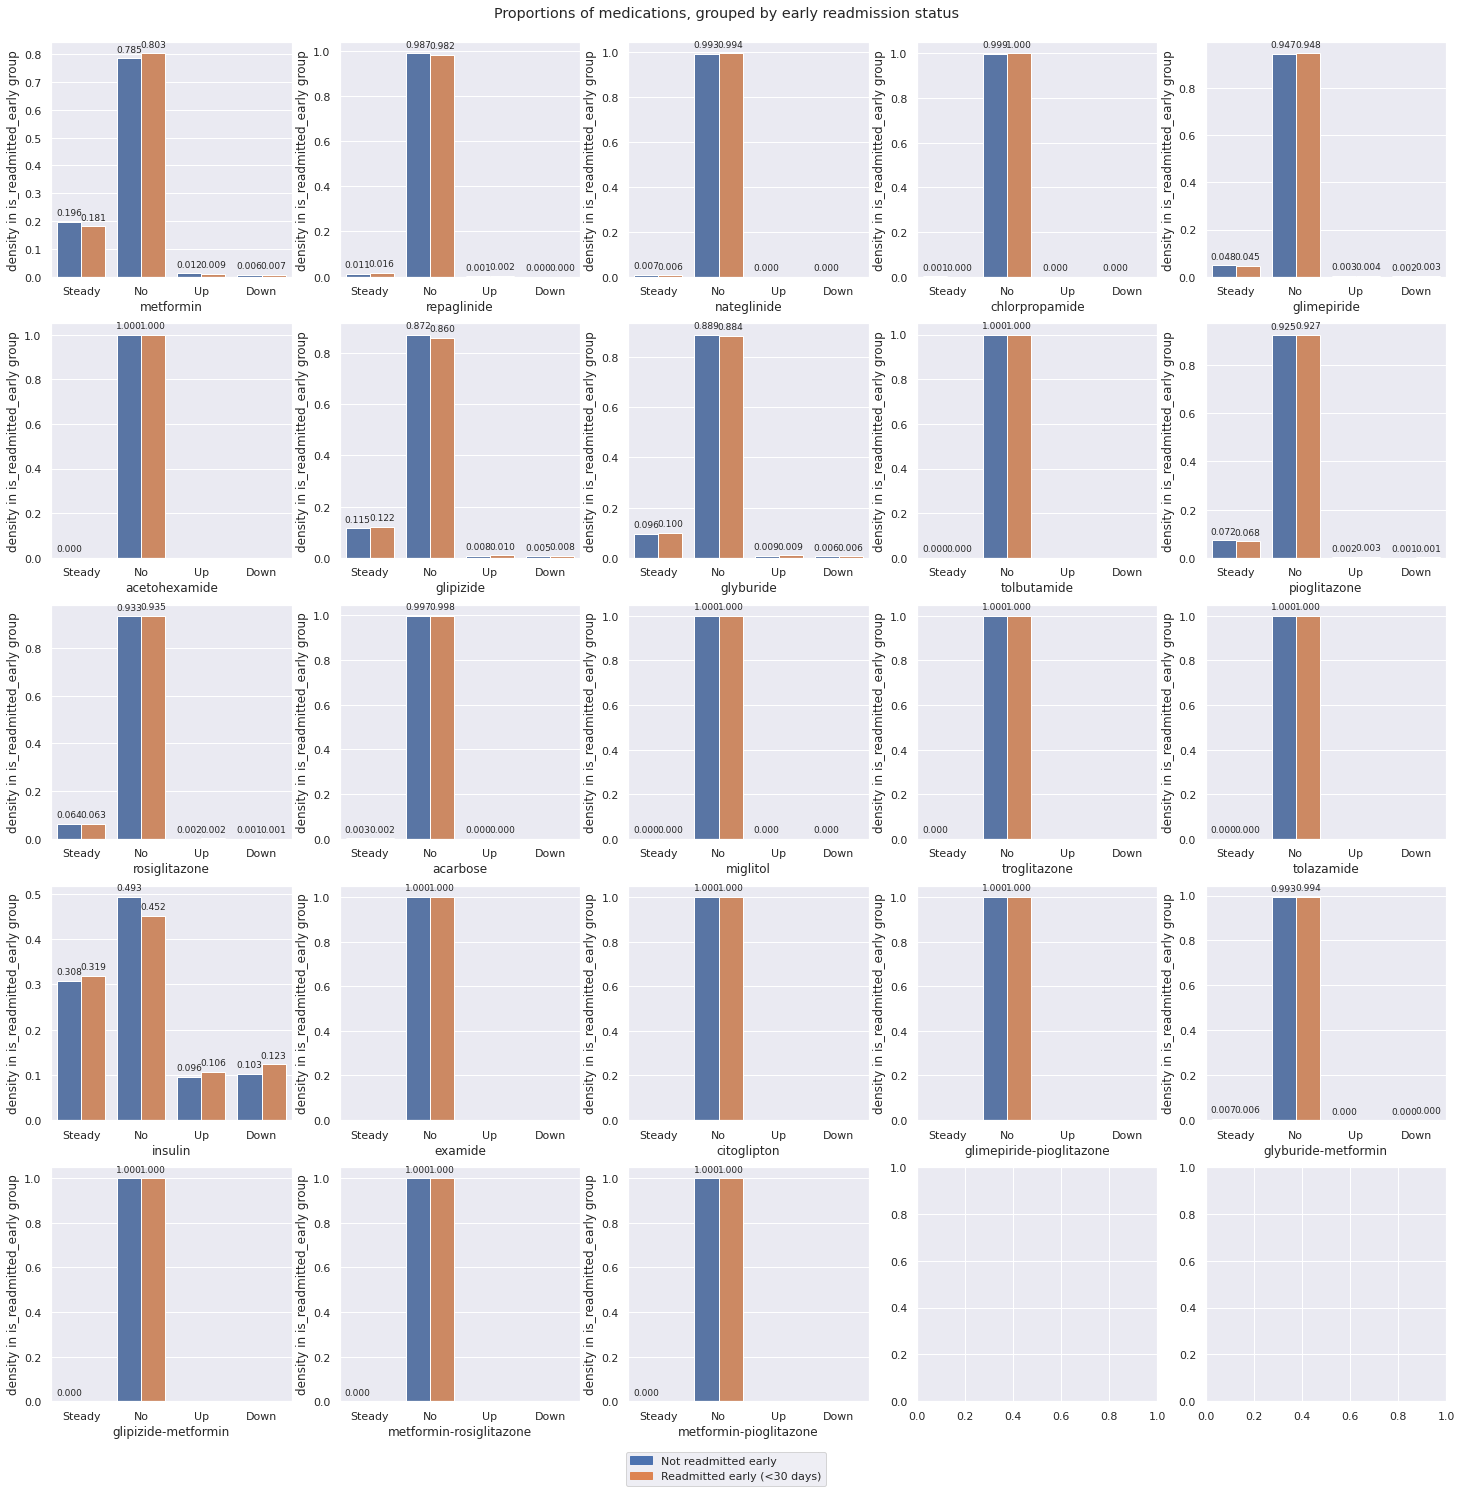

In [38]:
medication_features = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'examide', 'citoglipton', 'glimepiride-pioglitazone',
       'glyburide-metformin', 'glipizide-metformin', 'metformin-rosiglitazone', 'metformin-pioglitazone']

nrows = 5
ncols = 5
fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
fig.set_figheight(25)
fig.set_figwidth(25)

axes_iter = iter(axes.flatten())

for i, f in enumerate(medication_features):
    ax = next(axes_iter)
    viz.grouped_bar_plot(feature_name=f, df=df, groupby='is_readmitted_early', ax=ax, title='')
    ax.get_legend().remove()
    
blue = mpatches.Patch(color=sns.color_palette()[0], label='Not readmitted early')
orange = mpatches.Patch(color=sns.color_palette()[1], label='Readmitted early (<30 days)')
_ = fig.legend(handles=[blue, orange], loc='lower center', bbox_to_anchor=(0.5, 0.075))
_ = fig.suptitle('Proportions of medications, grouped by early readmission status', y=0.9)

del blue
del orange
del axes_iter

Many of these medications are mostly homogeneous. Exceptions are insulin and metformin. The early readmission group had a slightly higher proportion of patients who had not been taking metformin during their initial encounter. The non-early readmission group had a higher proportion of patients who were not taking insulin during their initial encounter.  Insulin is required for type 1 diabetic patients but not for type 2, which often produces milder symptoms than those of type 1.

Features like tolazamide, tolbutamide, troglitazone, metformin-pioglitazone, metformin-rosiglitazone, examide,  citoglipton, acetohexamide, and glimepiride-pioglitazone are fairly homogeneous. We'll investigate further to see the actually number of observations that have heterogeneous values:

In [39]:
medication_counts = pd.DataFrame()
for f in medication_features:
    medication_counts = pd.concat([medication_counts, df[f].value_counts(normalize=True, dropna=False).to_frame().T], axis=0)
    
medication_counts

,Steady,No,Up,Down
metformin,0.194847,0.787018,0.011919,0.006217
repaglinide,0.011690,0.986895,0.001015,0.000400
nateglinide,0.006674,0.992983,0.000229,0.000114
chlorpropamide,0.000943,0.998985,0.000057,0.000014
glimepiride,0.047604,0.947165,0.003287,0.001944
acetohexamide,0.000014,0.999986,0.000000,0.000000
glipizide,0.115230,0.871279,0.008189,0.005302
glyburide,0.096380,0.888886,0.008761,0.005974
tolbutamide,0.000243,0.999757,0.000000,0.000000
pioglitazone,0.071513,0.924785,0.002544,0.001158


Examide, citoglipton, and glimepiride-pioglitazone are completely homogeneous, and can be removed. Troglitazone, metformin-pioglitazone, gimepiride-pioglitazone, acetohexamide, and metformin-rosiglitazone all 3 observations or fewer that have patients who are taking them. In the feature engineering step, I feel comfortable with removing these columns to avoid adding unnecessary noise to our model. This also reduces our dimensionality quite a bit.

## 13. Numerical features

We have 9 numerical features: age, days in hospital, number of lab procedures, number of procedures, number of medications, number of outpatient encounters, number of inpatient encounters, number of emergency encounters, and number of diagnoses. A characteristic of these features are that they all consist of non-negative integer values.

In [101]:
# Build dataframe of only numerical features
numerical_df = df[numerical_features + ['is_readmitted_early']].copy()
numerical_df.age = age_to_index(numerical_df.age)
numerical_df['is_readmitted_early'] = numerical_df.is_readmitted_early.astype(int)
numerical_df

,,age,days_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,is_readmitted_early
encounter_id,patient_nbr,,,,,,,,,,
12522,48330783,8,13,68,2,28,0,0,0,8,0
15738,63555939,9,12,33,3,18,0,0,0,8,0
16680,42519267,4,1,51,0,8,0,0,0,5,0
28236,89869032,4,9,47,2,17,0,0,0,9,0
35754,82637451,5,3,31,6,16,0,0,0,9,0
...,...,...,...,...,...,...,...,...,...,...,...
443842016,183087545,7,9,50,2,33,0,0,0,9,0
443842022,188574944,4,14,73,6,26,0,1,0,9,0
443842070,140199494,6,2,46,6,17,1,1,1,9,0


### 13.1 Pair plots and correlation

We first construct pair plots to visualize the distribution of each numerical feature and  also plot them against every other numerical feature. We distinguish between early and non-early readmission groups to determine effective separating factors.

In [42]:
def generate_sample_indices(df, random_seed=0):
    """
    To reduce the number of observations and lower computation time of generating pairplots, 
    randomly downsample the majority class to have its size be equal to that of the minority class
    """
    readmitted_early = df.loc[df.is_readmitted_early == 1, :]
    not_readmitted_early  = df.loc[df.is_readmitted_early == 0, :].sample(readmitted_early.shape[0], random_state=random_seed)
    return readmitted_early.index.union(not_readmitted_early.index)

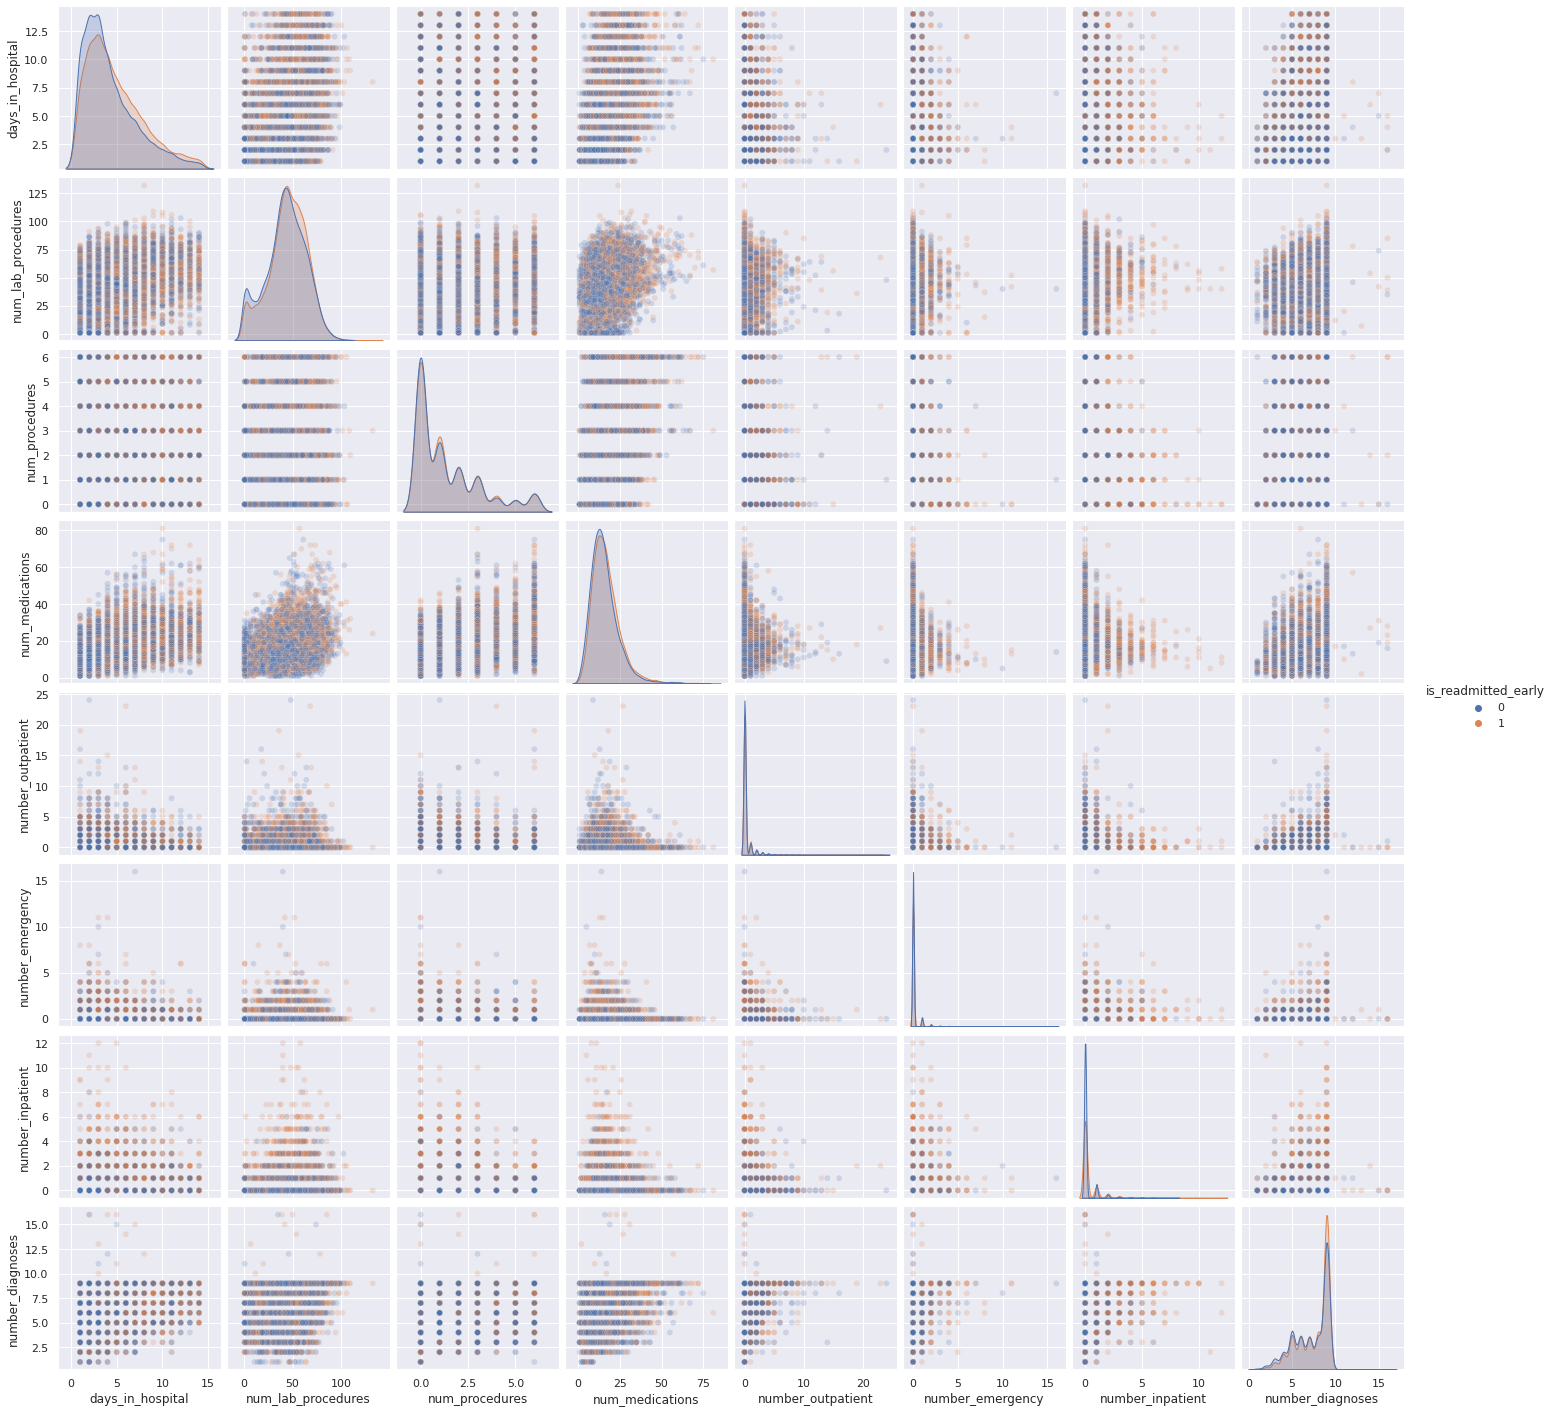

In [108]:
_ = sns.pairplot(data=df.loc[generate_sample_indices(numerical_df), numerical_features + ['is_readmitted_early']], hue='is_readmitted_early', diag_kind='kde',  plot_kws={'alpha':0.2})

Most of these scatter plots show little to no discrimination between early and non-early readmission patients. There are pairs like (high number_diagnoses, high number_inpatient), (low number_outpatient, high number_inpatient), (high days_in_hospital, high number_inpatient), (high number_inpatient, low number_emergency) that tend to have many positive observations. However, there exist other positive observations in these plots that occur under the same conditions as many other negative observations, indicating that these potentially discriminatory patterns are not very strong.

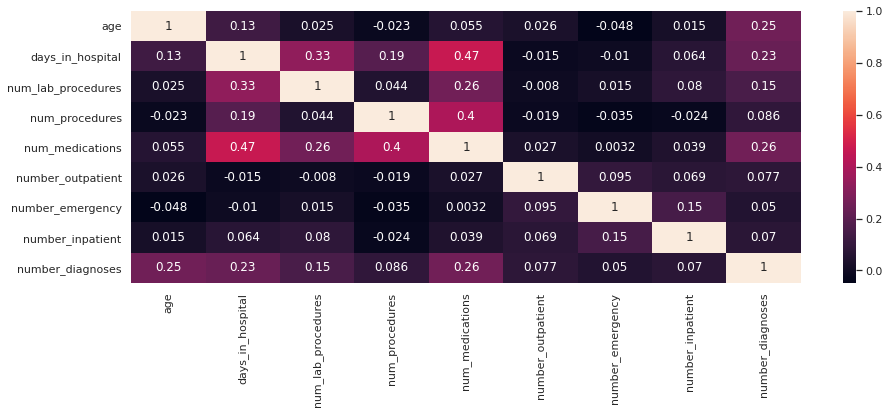

In [44]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(15)
corr = numerical_df[numerical_features].corr()
_ = sns.heatmap(corr, annot=True, ax=ax)

There are noticeable correlations between number of medications and number of procedures and number of days in the hospital and number of medications. 

### 13.2 Distribution Shape and Normality

Let's now take a closer look at the distribution shape of each numerical variable.

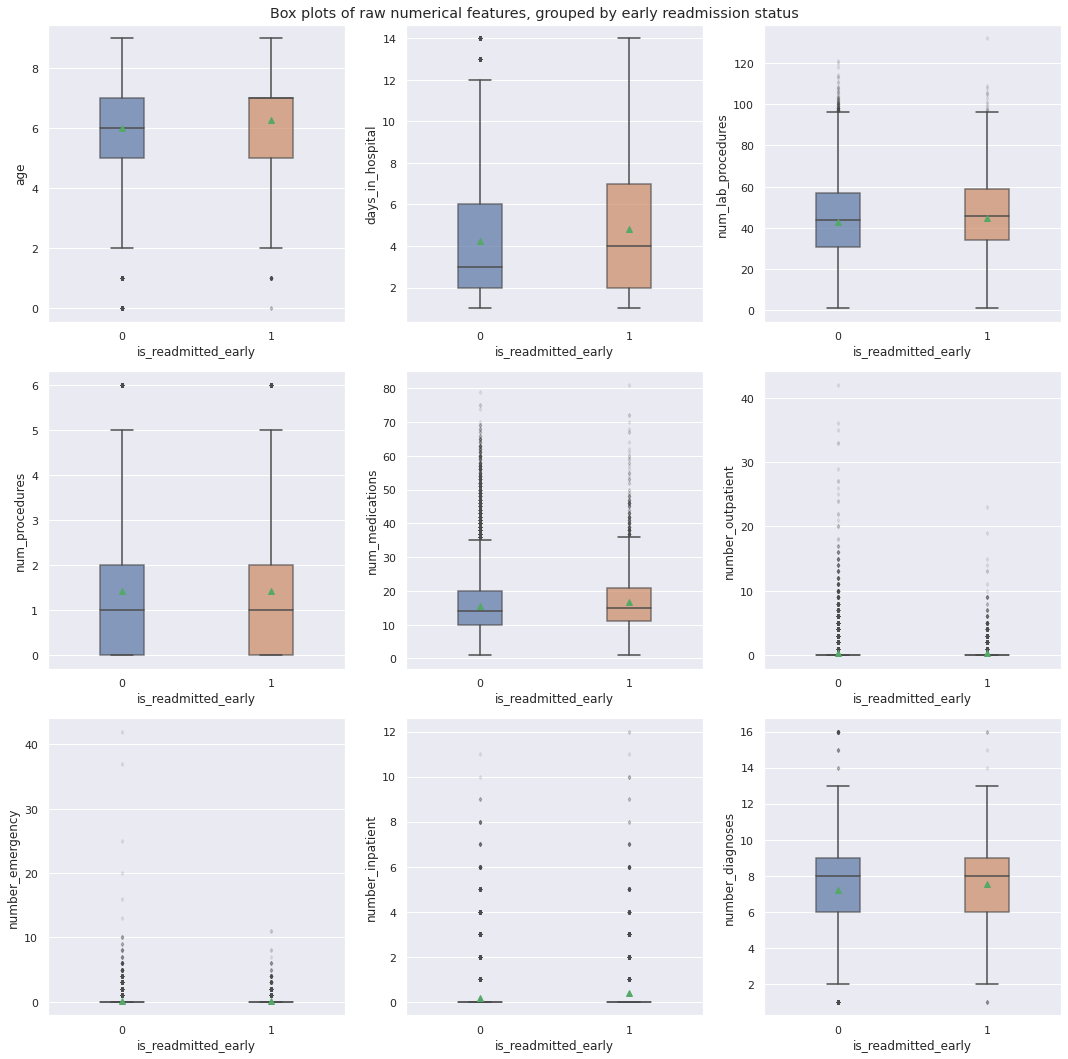

In [45]:
fig, axes = plt.subplots(3, 3)
fig.set_figheight(15)
fig.set_figwidth(15)

axes_iter = iter(axes.flatten())
for c in numerical_features:
    ax = next(axes_iter)
    _ = viz.grouped_box_plot(feature_name=c, groupby='is_readmitted_early', df=numerical_df, ax=ax)
    
plt.suptitle('Box plots of raw numerical features, grouped by early readmission status')
plt.tight_layout()

del axes_iter

There are several left-and right-skewed distributions.
- age: The non-early readmission group is approximately normal, and the early readmission group appears to be skewed left.
- days_in_hospital: Both groups right-skewed
- num_lab_procedures: Both groups are approximately normal but with several outliers
- num_procedures: Both groups right-skewed
- num_medications: Both groups are approximately normal (perhaps the early readmission group being slightly skewed right), but with several outliers
- number_outpatient, number_emergency, number_inpatient: Both groups have several positive outliers
- number_diagnoses: Slightly left-skewed with some outliers

Note that the distributions between target groups are very similar, with an exception being perhaps the number of days in the hospital, where patients who have readmitted early tended to spent more days in the year on average. We will investigate some of the outliers across these features:

In [46]:
num_lab_procedures_outliers = outliers_by_iqr(numerical_df, 'num_lab_procedures')
num_lab_procedures_outliers.describe()

,age,days_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,is_readmitted_early
count,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000
mean,5.367347,8.908163,101.887755,2.714286,26.918367,0.193878,0.132653,0.275510,8.510204,0.142857
std,1.725418,3.029364,6.157524,2.153874,10.813006,0.530671,0.510463,0.939188,1.114524,0.351726
min,1.000000,2.000000,97.000000,0.000000,8.000000,0.000000,0.000000,0.000000,5.000000,0.000000
25%,4.000000,7.000000,98.000000,1.000000,19.000000,0.000000,0.000000,0.000000,9.000000,0.000000
50%,6.000000,9.000000,100.000000,2.000000,26.000000,0.000000,0.000000,0.000000,9.000000,0.000000
75%,6.750000,11.750000,103.750000,5.000000,32.000000,0.000000,0.000000,0.000000,9.000000,0.000000
max,9.000000,14.000000,132.000000,6.000000,66.000000,3.000000,4.000000,6.000000,9.000000,1.000000


In [47]:
num_lab_procedures_outliers.is_readmitted_early.value_counts()

0    84
1    14
Name: is_readmitted_early, dtype: int64

There are only 98 observations with an outlying number of lab procedures. The maximum is 132, which seems like an unreasonably extreme value on face value but is not as vast of a departure from the other observations, centered at 42.

These outlying cases are not particular discriminatory in that its corresponding patient encounters do not show a clear preference for a readmission status group (84:14, which more or less reflects the 9:1 distribution of early to not-early observations in the entire dataset). I'm leaning toward removing these observations but may experiment with both leaving them and removing them. We observe similar data from number of medications below:

In [48]:
del num_lab_procedures_outliers

In [49]:
outliers_by_iqr(numerical_df, 'num_medications').describe()

,age,days_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,is_readmitted_early
count,1867.000000,1867.000000,1867.000000,1867.000000,1867.000000,1867.000000,1867.000000,1867.000000,1867.000000,1867.000000
mean,5.970541,8.349759,59.006963,4.307981,43.922335,0.192823,0.053026,0.146224,7.963578,0.101232
std,1.166103,3.015377,16.648000,1.765440,7.625258,0.653371,0.269721,0.492756,1.589003,0.301716
min,2.000000,1.000000,1.000000,0.000000,36.000000,0.000000,0.000000,0.000000,2.000000,0.000000
25%,5.000000,6.000000,47.000000,3.000000,38.000000,0.000000,0.000000,0.000000,7.000000,0.000000
50%,6.000000,8.000000,58.000000,5.000000,42.000000,0.000000,0.000000,0.000000,9.000000,0.000000
75%,7.000000,11.000000,71.000000,6.000000,48.000000,0.000000,0.000000,0.000000,9.000000,0.000000
max,9.000000,14.000000,106.000000,6.000000,81.000000,8.000000,4.000000,6.000000,16.000000,1.000000


In [50]:
number_outpatient_outliers = outliers_by_iqr(numerical_df, 'number_outpatient')
number_outpatient_outliers.describe()

,age,days_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,is_readmitted_early
count,9119.000000,9119.000000,9119.000000,9119.000000,9119.000000,9119.000000,9119.000000,9119.000000,9119.000000,9119.000000
mean,6.167453,4.081040,41.323939,1.328545,16.442702,2.144972,0.258910,0.313412,7.680667,0.101766
std,1.497431,2.800157,21.308756,1.636449,7.845821,2.164854,0.857192,0.823692,1.789728,0.302356
min,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,5.000000,2.000000,26.000000,0.000000,11.000000,1.000000,0.000000,0.000000,6.000000,0.000000
50%,6.000000,3.000000,43.000000,1.000000,15.000000,1.000000,0.000000,0.000000,9.000000,0.000000
75%,7.000000,5.000000,57.000000,2.000000,20.000000,3.000000,0.000000,0.000000,9.000000,0.000000
max,9.000000,14.000000,118.000000,6.000000,72.000000,42.000000,42.000000,12.000000,16.000000,1.000000


`number_outpatient` tracks the number of outpatient visits a patient has had in a year. Many observations were flagged as outliers because the majority of the dataset has 0 outpatient visits. As observed above, a single outpatient visit per year is considered an outlier. Because of this, I'm considering these valid outliers and deciding not to remove them. 

In [51]:
number_inpatient_outliers = outliers_by_iqr(numerical_df, 'number_inpatient')
number_inpatient_outliers.describe()

,age,days_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,is_readmitted_early
count,8191.000000,8191.000000,8191.000000,8191.000000,8191.000000,8191.000000,8191.000000,8191.000000,8191.000000,8191.000000
mean,6.196069,4.842632,47.208399,1.330241,16.655231,0.491637,0.273837,1.505677,7.673544,0.154072
std,1.523007,3.181067,19.170169,1.623233,7.657953,1.443066,0.977699,1.044404,1.765047,0.361039
min,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,5.000000,2.000000,36.000000,0.000000,12.000000,0.000000,0.000000,1.000000,6.000000,0.000000
50%,6.000000,4.000000,48.000000,1.000000,16.000000,0.000000,0.000000,1.000000,9.000000,0.000000
75%,7.000000,7.000000,61.000000,2.000000,20.000000,0.000000,0.000000,2.000000,9.000000,0.000000
max,9.000000,14.000000,109.000000,6.000000,72.000000,29.000000,42.000000,12.000000,16.000000,1.000000


In [52]:
len(number_inpatient_outliers.index.intersection(number_outpatient_outliers.index)) / len(number_inpatient_outliers)

0.21718959833964108

`number_inpatient` tracks the number of inpatient encounters a patient has per year. Similarly to outpatient encounters, non-zero inpatient encounters are considered outliers. Thus, we will opt to keep these observations.

Surprisingly, only about 22% of patients with outlying number of inpatient encounters have an outlying number of outpatient encounters.

In [53]:
number_emergency_outliers = outliers_by_iqr(numerical_df, 'number_emergency')
number_emergency_outliers.describe()

,age,days_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,is_readmitted_early
count,5100.000000,5100.000000,5100.000000,5100.000000,5100.000000,5100.000000,5100.000000,5100.000000,5100.000000,5100.000000
mean,5.860392,4.213529,44.106471,1.183137,15.994510,0.705490,1.425686,0.481373,7.707451,0.120196
std,1.694019,2.866530,20.387736,1.581725,7.498341,1.694427,1.307935,1.061663,1.846615,0.325223
min,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,5.000000,2.000000,31.000000,0.000000,11.000000,0.000000,1.000000,0.000000,7.000000,0.000000
50%,6.000000,3.000000,45.000000,1.000000,15.000000,0.000000,1.000000,0.000000,9.000000,0.000000
75%,7.000000,6.000000,59.000000,2.000000,20.000000,1.000000,1.000000,1.000000,9.000000,0.000000
max,9.000000,14.000000,132.000000,6.000000,64.000000,29.000000,42.000000,12.000000,16.000000,1.000000


Of the population who had an outlying number of emergency visits, the proportion of observations who had an outlying number of out-patient visits:

In [54]:
len(number_emergency_outliers.index.intersection(number_outpatient_outliers.index)) / len(number_emergency_outliers)

0.3037254901960784

Of the population who had an outlying number of emergency visits, the proportion of observations who had an outlying number of in-patient visits:

In [55]:
len(number_emergency_outliers.index.intersection(number_inpatient_outliers.index)) / len(number_emergency_outliers)

0.26941176470588235

Of the population who had an outlying number of emergency visits, the proportion of observations who had an outlying number of in-patient visits or an outlying number of out-patient visits:

In [56]:
i = number_emergency_outliers.index.intersection(number_inpatient_outliers.index)
o = number_emergency_outliers.index.intersection(number_outpatient_outliers.index)
u = i.union(o)

del i; del o;
len(u) / len(number_emergency_outliers)

0.4766666666666667

`number_emergency` tracks the number of emergency visits a patient had within the year. There are 5100 observations with outlying `number_emergency` values. The percentage of patients who have outlying emergency visits and out-patient encounters is about 30%. The percentage of patients who have outlying emergency visits and in-patient encounters is about 27%. The percentage of patients who have outlying emergency visits and outlying in-patient or out-patient encounters is about 48%. Similarly, we opt to keep these observations.

In [57]:
del number_emergency_outliers; del number_inpatient_outliers; del number_outpatient_outliers

In [58]:
scaler = StandardScaler()
scaler.fit(numerical_df[numerical_features])
scaled_features = scaler.transform(numerical_df[numerical_features])
scaled_features = np.concatenate([scaled_features, numerical_df.is_readmitted_early.to_numpy().reshape(-1, 1)], axis=1)
scaled_features_df = pd.DataFrame(scaled_features, columns=numerical_df.columns)
scaled_features_df.describe()

,age,days_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,is_readmitted_early
count,6.997300e+04,6.997300e+04,6.997300e+04,6.997300e+04,6.997300e+04,6.997300e+04,6.997300e+04,6.997300e+04,6.997300e+04,69973.000000
mean,1.376954e-16,-4.874173e-17,-1.584106e-16,2.599559e-17,-4.874173e-17,8.123622e-19,-1.624724e-18,-3.127594e-17,1.852186e-16,0.089706
std,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,0.285762
min,-3.783709e+00,-1.115654e+00,-2.104917e+00,-8.112916e-01,-1.769630e+00,-2.627154e-01,-2.030050e-01,-2.929491e-01,-3.109789e+00,0.000000
25%,-6.535886e-01,-7.748108e-01,-5.969542e-01,-8.112916e-01,-6.836164e-01,-2.627154e-01,-2.030050e-01,-2.929491e-01,-6.114622e-01,0.000000
50%,-2.756463e-02,-4.339679e-01,5.649644e-02,-2.421780e-01,-2.009435e-01,-2.627154e-01,-2.030050e-01,-2.929491e-01,3.878685e-01,0.000000
75%,5.984594e-01,5.885609e-01,7.099471e-01,3.269355e-01,5.230657e-01,-2.627154e-01,-2.030050e-01,-2.929491e-01,8.875338e-01,0.000000
max,1.850507e+00,3.315304e+00,4.479854e+00,2.603390e+00,7.883827e+00,3.920994e+01,8.184959e+01,1.965210e+01,4.385191e+00,1.000000


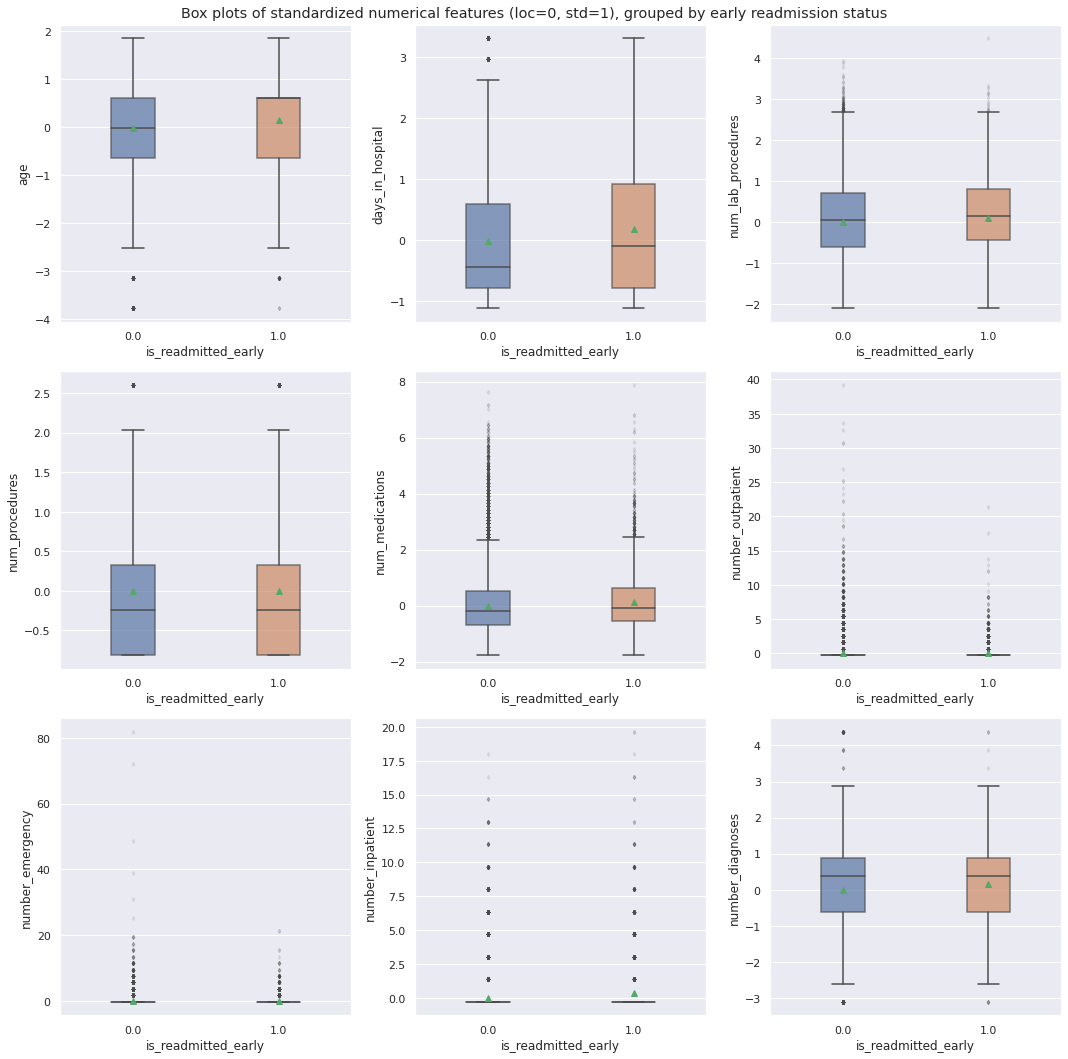

In [59]:
fig, axes = plt.subplots(3, 3)
fig.set_figheight(15)
fig.set_figwidth(15)
axes_iter = iter(axes.flatten())

for f in numerical_features:
    ax = next(axes_iter)
    _ = viz.grouped_box_plot(feature_name=f, groupby='is_readmitted_early', df=scaled_features_df, ax=ax)
    
plt.suptitle('Box plots of standardized numerical features (loc=0, std=1), grouped by early readmission status')
plt.tight_layout()
del axes_iter

Another approach to assess whether the feature distributions are normal is to plot QQ (quantile-quantile) plots. Here, we can plot the theoretical normal distribution (mean=0, std=1) quantiles by the quantiles of the distribution we are evaluating.

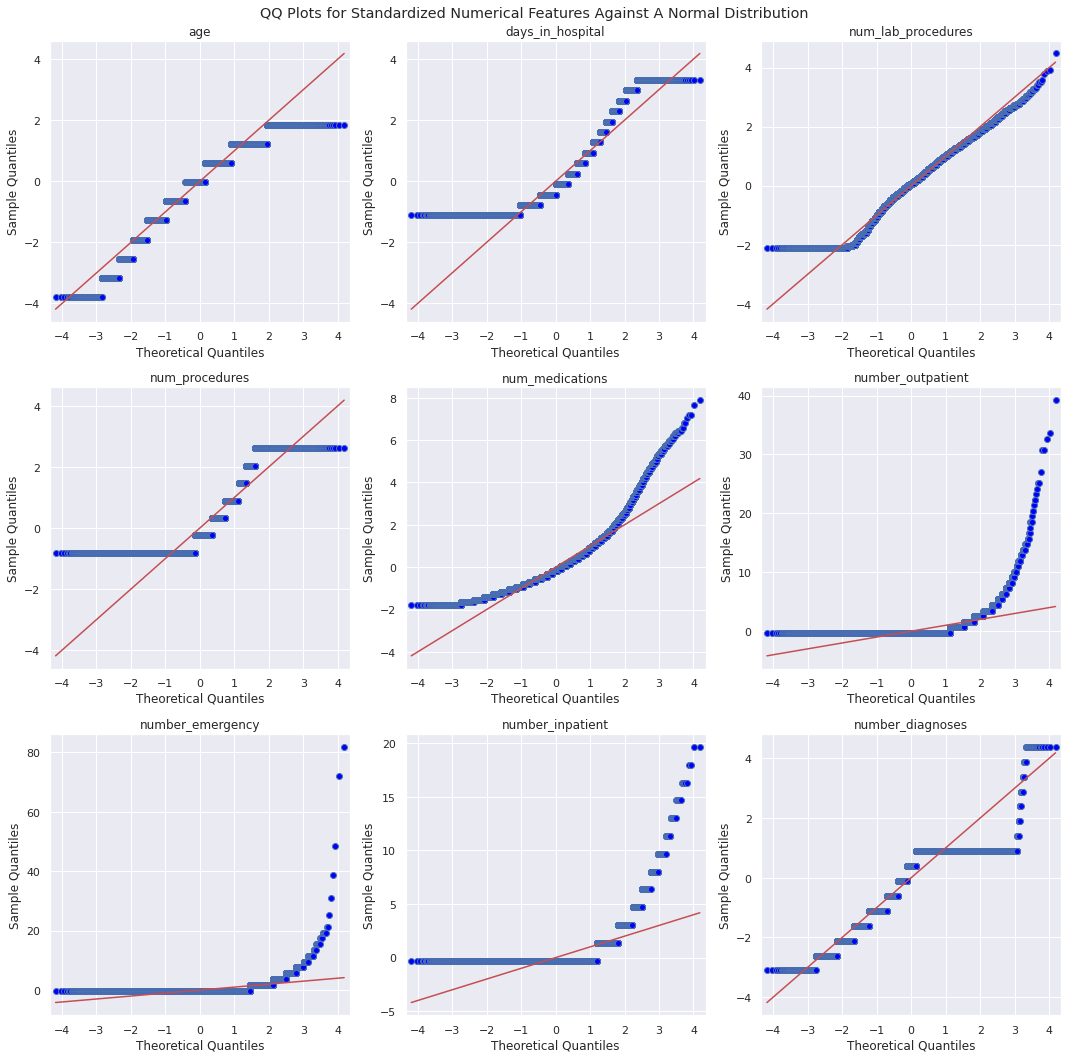

In [60]:
fig, axes = plt.subplots(3, 3)
fig.set_figheight(15)
fig.set_figwidth(15)

axes_iter = iter(axes.flatten())

for f in numerical_features:
    ax = next(axes_iter)
    qqplot(scaled_features_df[f], line='s', ax=ax)
    ax.set_title(f)
    
plt.suptitle('QQ Plots for Standardized Numerical Features Against A Normal Distribution')    
plt.tight_layout()
del axes_iter

Based on the above QQ-plots, none of the standardized numerical features appear to follow a normal distribution.

In [82]:
log_transformed_df = numerical_df.copy()

transformed_features = []

for f in numerical_features:
    s = ss.skew(numerical_df[f])
    if s < -0.5:
        print(f'Power transforming: {f}')
        tf = f + '_sq'
        # Transform left-skewed feature by square transformation
        log_transformed_df[tf] = numerical_df[f] ** 2
        transformed_features.append(tf)
    elif s > 0.5: 
        print(f'Log-transforming {f}')
        tf = f + '_log1p'
        # Transform right-skewed feature by logarithmic transformation
        log_transformed_df[tf] = np.log1p(numerical_df[f])
        transformed_features.append(tf)
    else:
        print(f'No transformation: {f}')
        transformed_features.append(f)

log_transformed_df.describe()

Power transforming: age
Log-transforming days_in_hospital
No transformation: num_lab_procedures
Log-transforming num_procedures
Log-transforming num_medications
Log-transforming number_outpatient
Log-transforming number_emergency
Log-transforming number_inpatient
Power transforming: number_diagnoses


,age,days_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,is_readmitted_early,age_sq,days_in_hospital_log1p,num_procedures_log1p,num_medications_log1p,number_outpatient_log1p,number_emergency_log1p,number_inpatient_log1p,number_diagnoses_sq
count,69973.000000,69973.000000,69973.000000,69973.000000,69973.000000,69973.000000,69973.000000,69973.000000,69973.000000,69973.000000,69973.000000,69973.000000,69973.000000,69973.000000,69973.000000,69973.000000,69973.000000,69973.000000
mean,6.044031,4.273220,42.876038,1.425536,15.665257,0.279536,0.103912,0.176254,7.223743,0.089706,39.081946,1.519970,0.654046,2.693978,0.133775,0.060533,0.101039,56.187830
std,1.597394,2.933924,19.894530,1.757131,8.287246,1.064035,0.511870,0.601657,2.001354,0.285762,18.047733,0.532626,0.664992,0.503440,0.379499,0.229204,0.296067,26.349985
min,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.693147,0.000000,0.693147,0.000000,0.000000,0.000000,1.000000
25%,5.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000,0.000000,25.000000,1.098612,0.000000,2.397895,0.000000,0.000000,0.000000,36.000000
50%,6.000000,3.000000,44.000000,1.000000,14.000000,0.000000,0.000000,0.000000,8.000000,0.000000,36.000000,1.386294,0.693147,2.708050,0.000000,0.000000,0.000000,64.000000
75%,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,0.000000,9.000000,0.000000,49.000000,1.945910,1.098612,3.044522,0.000000,0.000000,0.000000,81.000000
max,9.000000,14.000000,132.000000,6.000000,81.000000,42.000000,42.000000,12.000000,16.000000,1.000000,81.000000,2.708050,1.945910,4.406719,3.761200,3.761200,2.564949,256.000000


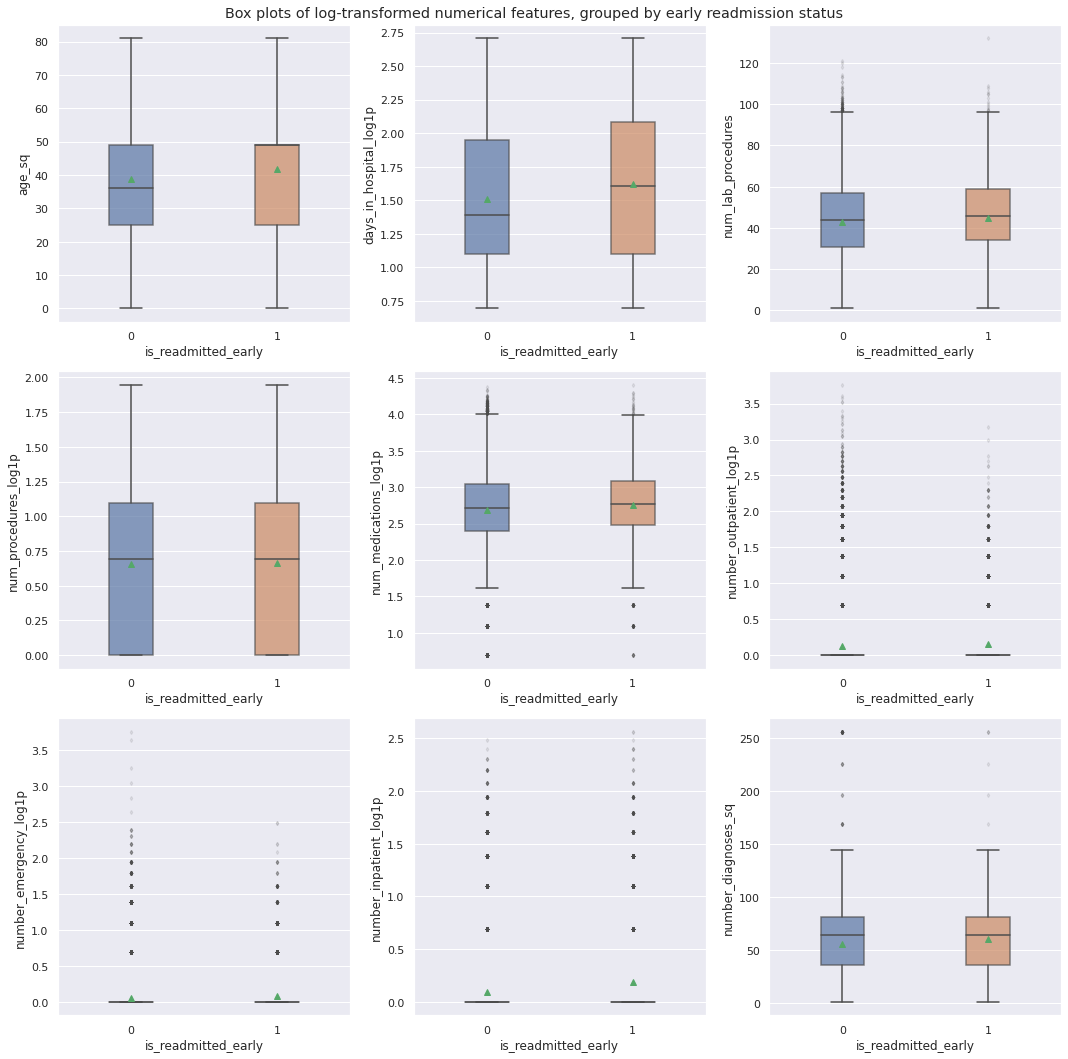

In [84]:
fig, axes = plt.subplots(3, 3)
fig.set_figheight(15)
fig.set_figwidth(15)

axes_iter = iter(axes.flatten())
for f in transformed_features:
    ax = next(axes_iter)
    _ = viz.grouped_box_plot(feature_name=f, groupby='is_readmitted_early', df=log_transformed_df, ax=ax)
    
plt.suptitle('Box plots of log-transformed numerical features, grouped by early readmission status')
plt.tight_layout()

del axes_iter

In [85]:
scaler = StandardScaler()
scaler.fit(log_transformed_df[transformed_features])
scaled_transformed_features = scaler.transform(log_transformed_df[transformed_features])
scaled_transformed_features = np.concatenate([scaled_transformed_features, log_transformed_df.is_readmitted_early.to_numpy().reshape(-1, 1)], axis=1)
scaled_transformed_features_df = pd.DataFrame(scaled_transformed_features, columns=transformed_features + ['is_readmitted_early'])
log_transformed_df[transformed_features]

,,age_sq,days_in_hospital_log1p,num_lab_procedures,num_procedures_log1p,num_medications_log1p,number_outpatient_log1p,number_emergency_log1p,number_inpatient_log1p,number_diagnoses_sq
encounter_id,patient_nbr,,,,,,,,,
12522,48330783,64,2.639057,68,1.098612,3.367296,0.000000,0.000000,0.000000,64
15738,63555939,81,2.564949,33,1.386294,2.944439,0.000000,0.000000,0.000000,64
16680,42519267,16,0.693147,51,0.000000,2.197225,0.000000,0.000000,0.000000,25
28236,89869032,16,2.302585,47,1.098612,2.890372,0.000000,0.000000,0.000000,81
35754,82637451,25,1.386294,31,1.945910,2.833213,0.000000,0.000000,0.000000,81
...,...,...,...,...,...,...,...,...,...,...
443842016,183087545,49,2.302585,50,1.098612,3.526361,0.000000,0.000000,0.000000,81
443842022,188574944,16,2.708050,73,1.945910,3.295837,0.000000,0.693147,0.000000,81
443842070,140199494,36,1.098612,46,1.945910,2.890372,0.693147,0.693147,0.693147,81


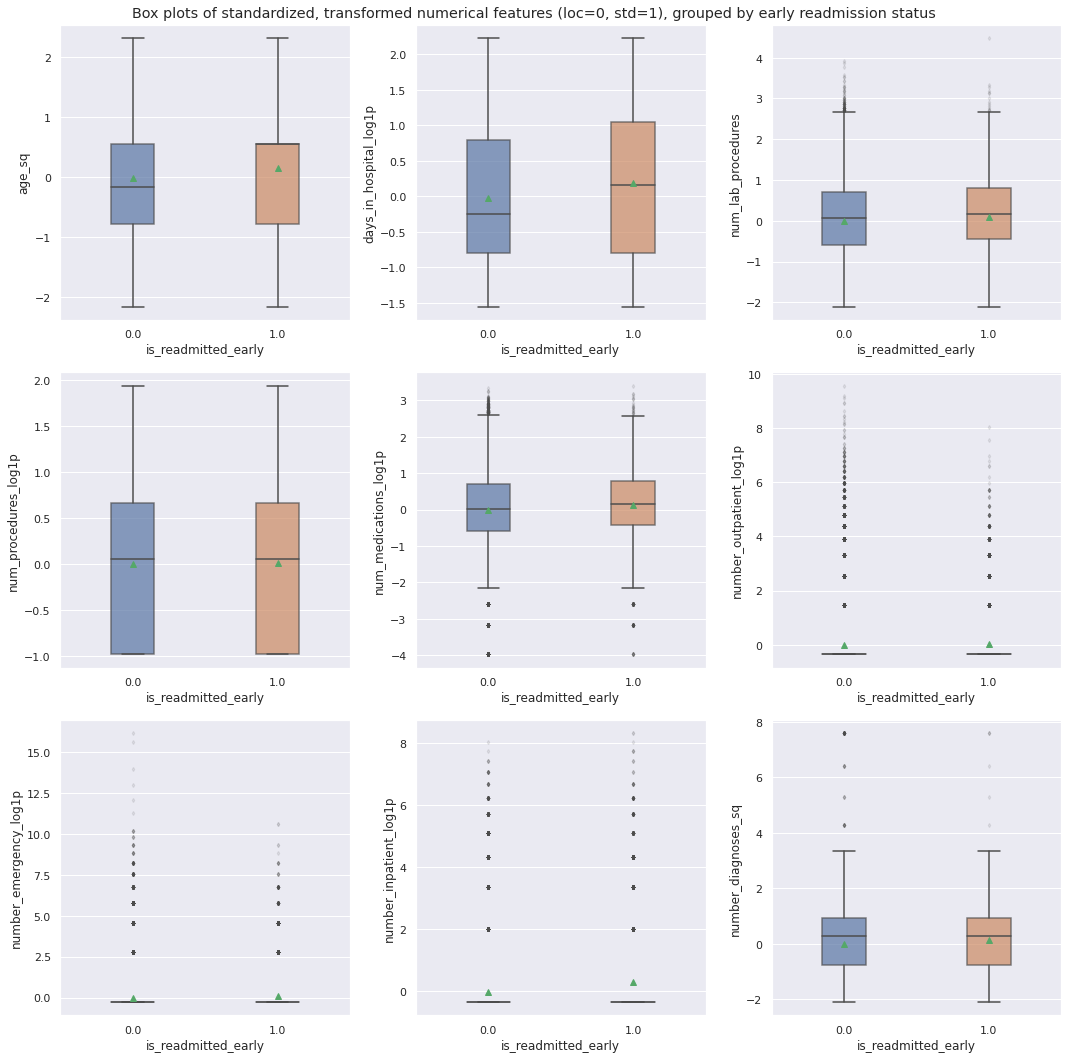

In [100]:
fig, axes = plt.subplots(3, 3)
fig.set_figheight(15)
fig.set_figwidth(15)
axes_iter = iter(axes.flatten())

for f in transformed_features:
    ax = next(axes_iter)
    _ = viz.grouped_box_plot(feature_name=f, groupby='is_readmitted_early', df=scaled_transformed_features_df, ax=ax)
    
plt.suptitle('Box plots of standardized, transformed numerical features (loc=0, std=1), grouped by early readmission status')
plt.tight_layout()
del axes_iter

### 13.3 Combined Features

In [130]:
combined_features_df = pd.DataFrame()
combined_features_df['service_utilization'] = df.number_inpatient + df.number_outpatient + df.number_emergency
combined_features_df['total_increased_meds'] = df[medication_features].apply(lambda x: x == 'Up').sum(axis=1)
combined_features_df['total_decreased_meds'] = df[medication_features].apply(lambda x: x == 'Down').sum(axis=1)
combined_features_df['total_changed_meds'] = df[medication_features].apply(lambda x: (x == 'Up') | (x == 'Down')).sum(axis=1)

# entropy based on the diversity of diagnoses
combined_features_df['diagnosis_diversity'] = diagnosis_diversity(df.diag_1, df.diag_2, df.diag_3)

combined_features = combined_features_df.columns

combined_features_df['is_readmitted_early'] = df.is_readmitted_early

def compute_entropy(d1, d2, d3):
    diagnoses = [d1, d2, d3]
    num_diagnoses = len(diagnoses)
    prob_d1 = diagnoses.count(d1) / num_diagnoses
    prob_d2 = diagnoses.count(d2) / num_diagnoses
    prob_d3 = diagnoses.count(d3) / num_diagnoses
    return -(prob_d1 * np.log(prob_d1) + prob_d2 * np.log(prob_d2) + prob_d3 * np.log(prob_d3)) 

def diagnosis_diversity(diag_1, diag_2, diag_3):
    d1 = diag_1.apply(icd9_to_category)
    d2 = diag_2.apply(icd9_to_category)
    d3 = diag_3.apply(icd9_to_category)
    d = pd.concat([d1, d2, d3], axis=1)
    return d.apply(lambda r: compute_entropy(r.diag_1, r.diag_2, r.diag_3), axis=1)

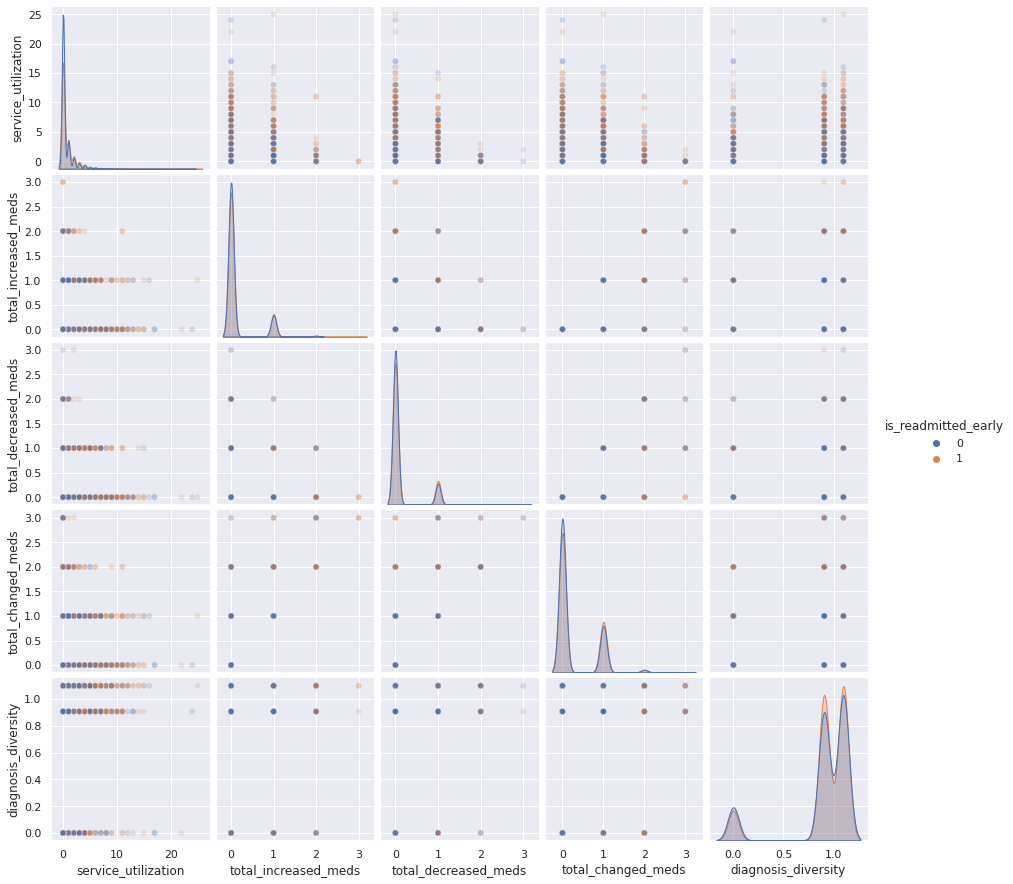

In [131]:
_ = sns.pairplot(data=combined_features_df.loc[generate_sample_indices(combined_features_df), combined_features_df.columns], hue='is_readmitted_early', diag_kind='kde',  plot_kws={'alpha':0.2})

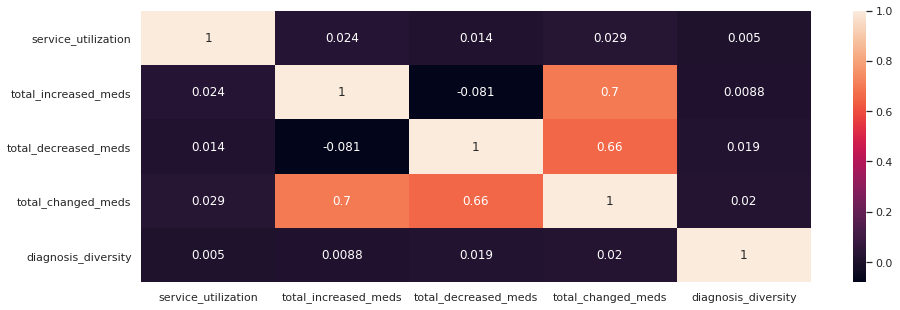

In [132]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(15)
corr = combined_features_df[combined_features].corr()
_ = sns.heatmap(corr, annot=True, ax=ax)

### 13.4 Dimensionality Reduction and Visualization

In [90]:
n_components = scaled_transformed_features_df.shape[1]
pca = PCA(n_components=n_components)
pca.fit(scaled_transformed_features_df)
transformed_X = pca.transform(scaled_transformed_features_df)

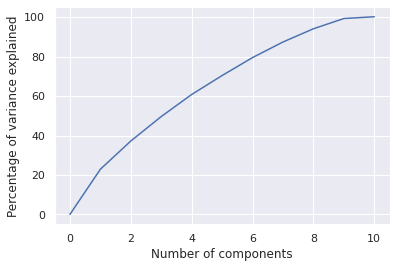

In [97]:
cumulative_variance = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)) * 100
cumulative_variance = np.insert(cumulative_variance, 0, 0.0)
ax = sns.lineplot(x=np.arange(0, n_components + 1), y=cumulative_variance)
_ = plt.xlabel('Number of components')
_ = plt.ylabel('Percentage of variance explained')

Our cumulative graph of variance explained by PCA resembles a logistic curve, meaning that we were not able to capture much of the data's variance by using only a few principal components.

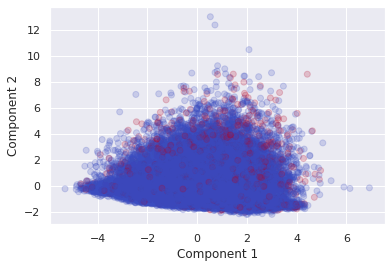

In [134]:
_ = plt.scatter(transformed_X[:, 0], transformed_X[:, 1], c=scaled_transformed_features_df.is_readmitted_early, cmap='coolwarm', alpha=0.2)
_ = plt.xlabel('Component 1')
_ = plt.ylabel('Component 2')

Above is a scatter plot of the data, transformed by principal component analysis across two components. The red indicates early readmitted patients. Two principal components only account for about one third of the variance in our numeric data and it does not discriminate our two classes well. The data takes the shape of striations, which are consistent with the fact that many of our numeric features contain integer values.

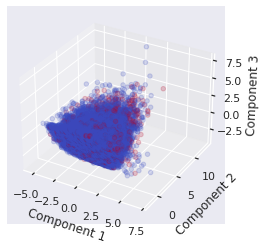

In [95]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
_ = ax.scatter(transformed_X[:, 0], transformed_X[:, 1], transformed_X[:, 2], c=scaled_transformed_features_df.is_readmitted_early, cmap='coolwarm', alpha=0.2)
_ = ax.set_xlabel('Component 1')
_ = ax.set_ylabel('Component 2')
_ = ax.set_zlabel('Component 3')

Using three components (about 37% of variance explained) does not appear to do a better job at discriminating between binary classes. At least from the lens of numeric features, the data lacks a straightforward pattern and linear separability.

## 14. Conclusion

In this notebook, we performed exploratory data analysis to find hidden or interesting patterns in our data. We first recognized the imbalanced nature of our dataset, where positive observations (patients who were readmitted early) only accounts for about 9% of our data.

In studying the distributions of discharge types between readmission groups, patients who were not readmitted early tended to be discharged to their home more often that the early readmission group.

We also observed that patients who had been readmitted early tended to be older, and more likely to be in the 70-90 age range than those who were not readmitted early.

Positive observations had a higher proportion of unavailable healthcare payer codes. This could indicate that (1) these patients tended to not have measures to pay for their treatment, that (2), circumstantially, these codes were neglected to be reported for a higher proportion of this group, or (3) some other reason unknown to us. Positive observations had a slightly higher proportion of Medicare payer codes, which may make sense in that Medicare, a national US healthcare program, is often given toward individuals 65 or older, or those with a pre-existing disability. Older patients may be more susceptible to severe illness, which may warrant earlier re-hospitalization. Overall, about 44% of all payer codes were unavailable so this may be an unreliable predictor of early readmission.

It appeared that patients who were readmitted early had a noticeably higher incidence of circulatory issues as a primary diagnosis (0.355 vs 0.324). Similarly, non-early patients have a higher incidence of respiratory illness as a primary diagnosis (0.148 vs 0.119). Circulatory diagnoses dominate all three diagnosis categories, but are not clearly favored by one group.

Interestingly, the non-early readmission group had a higher proportion of Diabetes diagnoses in both the secondary and tertiary diagnoses.

Regarding medications, the non-early readmission group had a higher proportion of patients who were not taking insulin during their initial encounter.  Insulin is required for type 1 diabetic patients but not for type 2, which often produces milder symptoms than those of type 1. This may make sense in that type 1 diabetic patients are at risk of auto-immune complications.

Many of our numerical features were non-negative integer variables, resembling right-skewed distributions. We examined outliers and realized that many were many were, in fact, valid or reasonable, and may encode some importance in distinguishing between the two target groups. Via log transformation, we were able to improve the normality of some of these features.

When attempting to reduce the dimensions of our standardized, transformed numerical features, we were unable to capture sufficient variance in a few components. When plotting the components along two and three dimensions, we realized that the numerical data was not easily linearly separable.